In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

This notebook details the tools relevant to continuation, namely ```dimension_continuation``` and ```discretization_continuation```.

In [16]:
s = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/streak/final_tile/EquilibriumOrbitKS_L6p39.h5'
w = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/gap/final_tile/AntisymmetricOrbitKS_T17p150_L17p591.h5'
m = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/defects/defect1/final_tile/RelativeOrbitKS_T15p855_L13p026.h5'

with h5py.File(m, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    m = RelativeOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(w, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    w = AntisymmetricOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(s, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    s = EquilibriumOrbitKS(state=dat, parameters=params, basis='field')
    
d = read_h5('../../data/local/thesis.h5', 'families/defect_large_family_member').transform(to='modes')

In [18]:
td = read_tileset('../../data/ks/tiles.h5', (0, 1, 2),
                  ('/default/double_streak','/default/defect','/default/wiggle'),
                  validate=False)
td[0].plot()
td[1].plot()
td[2].plot()
# td[0] = td[0].cell_shift(4, axis=1)

tile(np.array([[1],[0]]), td, OrbitKS).plot()

orbit_1_2 = tile(np.array([[1],[0]]), td, OrbitKS)  
orbit_1_2.plot()
result_12 = hunt(orbit_1_2.resize(8, 8).resize(16, 16).transform(to='modes'), 
                     method='hybrid', verbose=True, pexp=(1,4), preconditioning=True, comp_time='long')

1.8825457676874493e-14

In [10]:
td = read_fpo_set(tileset='resized', rescaled=True)
streak = td[0]
defect = td[1]
wiggle = td[2]

NameError: name 'read_fpo_set' is not defined

The first type of continuation is ```dimension_continuation``` which imposes constraints on the dimensions, performing
a multi-stepped optimization process. To demonstrate this, the 'defect' fundamental periodic orbit is converted back into
a RelativeOrbitKS; it was saved as an OrbitKS without symmetry because of how tiling works. 

In [4]:
defect = convert_class(td[1], RelativeOrbitKS).reshape(16,16).transform(to='modes')
defect = converge(defect, method='lstsq', verbose=True).orbit


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 38.27588459011695
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["17.1508", "13.0196", "3.235"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
#######
Converged. Exiting with residual 1.2941286777876588e-08


The first demonstration is that temporal continuation, fixing the temporal period, can be used instead of spatial continuation
which is less likely to succeed, *if* the temporal period corresponding to the spatial size is known. For example, let's say that we are targeting $L=13.08$ for the defect tile.


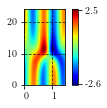

In [5]:
defect.plot()

In [2]:
# defect_spatial_continuation = dimension_continuation(defect, 13.08, step_size=0.025, axis=1, method='lstsq', verbose=True).orbit

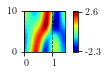

RelativeOrbitKS({"basis": "modes", "parameters": ["10.1105", "13.08", "3.7036"], "field_shape": ["16", "16"]})

In [7]:
defect_spatial_continuation.plot()
defect_spatial_continuation

This can also be performed in time to the same domain size, in order to achieve the approximately same orbit.

In [8]:
defect_spatial_continuation.T

10.110505916382113

In [9]:
defect.constraints

{'T': False, 'L': False, 'S': False}

In [3]:
# defect_temporal_continuation = dimension_continuation(defect, defect_spatial_continuation.T, step_size=8, axis=0,
#                                                       method='lstsq', verbose=True).orbit

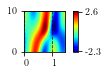

In [11]:
defect_temporal_continuation.plot()

It can also be useful to rediscretize and converge the result; this is accessible through ```discretization_continuation```;
provide the new field_shape and then the function will try to increment the discretization size by the specified amount;
the routine will always reshape in the most optimized manner, i.e. the smallest dimensions first.

if going from (16, 16)-> (32, 64), the shape goes to (16, 64) and then (32, 64) unless `cycle=True`, at which point discretization will cycle through the axes in order specified by the user via `axes_order` keyword argument.

For example: `axes_order=(1, 0)`, `initial_shape = (16, 16)`, `target_shape = (32, 64)` would rediscretize in sequence
(16, 18)->(18,18)->(18,20)-> ... -> (32, 64)

If, of course, the increment is specified to be 2 in each dimension.

In [4]:
# x = discretization_continuation(defect_temporal_continuation, (24, 24), step_sizes=(2,2), cycle=True, verbose=True)

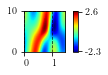

In [13]:
x.orbit.plot()

This is also automated through the ```span_family``` function. This function requires bounds, step_sizes, and the orbit to serve as the "root" of the branches.

In [2]:
keys = tuple(['defect', 'larger_defect', 'wiggle', 'drifter', 'streak'])
# keys = tuple(['streak', 'wiggle'])
names = tuple(['/default/'+k for k in keys])
root_orbits = read_tileset('../data/ks/tiles.h5', keys, names)

# drifter = continuation(root_orbits['defect'].transform(to='modes').resize(32, 32), {'x':13.2}, verbose=False, method='lstsq')
# root_orbits['drifter']=drifter
# root_orbits['larger_defect'].transform(to='modes')

In [17]:
for root in root_orbits:
    tmp = root_orbits[root].transform(to='modes').resize(32, 32)
    orb = hunt(tmp, methods='lstsq', tol=1e-10).orbit
    bounds = {'x': (orb.x-2, orb.x+2)}
    step_sizes = {'x': 0.001}
    span_family(orb, bounds=bounds, step_sizes=step_sizes,
                verbose=True, methods=('adj', 'lstsq'), ftol=0, preconditioning=True,
                maxiter=[32000, 500], tol=[1e-4, 1e-6],
                filename='covering_xcont.h5', groupname=root, h5mode='a')


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.151, 13.02, -3.313]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 5.599201680848184e-23
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.151, 13.02, -3.313]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 5.599201680848184e-23
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [16.599, 13.024, -3.325]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.726610801249731e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [16.599, 13.024, -3.325]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.726610801249731e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [15.918, 13.028, -3.342]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.73969884380493e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [15.918, 13.028, -3.342]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.73969884380493e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exitin


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [15.291, 13.032, -3.361]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7529385328246956e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [15.291, 13.032, -3.361]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7529385328246956e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Ex


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [14.711, 13.036, -3.382]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7656049407512165e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [14.711, 13.036, -3.382]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7656049407512165e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Ex


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [14.171, 13.04, -3.404]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7770083718445206e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [14.171, 13.04, -3.404]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7770083718445206e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [13.667, 13.044, -3.428]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7865312345652384e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [13.667, 13.044, -3.428]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7865312345652384e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Ex


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [13.195, 13.048, -3.454]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.793587770152508e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [13.195, 13.048, -3.454]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.793587770152508e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [12.751, 13.052, -3.48]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7975990848686534e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [12.751, 13.052, -3.48]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.7975990848686534e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [12.332, 13.056, -3.508]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.79798188841272e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [12.332, 13.056, -3.508]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.79798188841272e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exitin


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.936, 13.06, -3.536]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.794157069483483e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.936, 13.06, -3.536]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.794157069483483e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.56, 13.064, -3.566]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.908987216721321e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.56, 13.064, -3.566]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.908987216721321e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.202, 13.068, -3.596]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.92365435145873e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [11.202, 13.068, -3.596]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.92365435145873e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.86, 13.072, -3.628]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.936590602120647e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.86, 13.072, -3.628]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.936590602120647e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.533, 13.076, -3.659]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9474126421276314e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.533, 13.076, -3.659]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9474126421276314e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. E


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.219, 13.08, -3.692]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.95563087122344e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [10.219, 13.08, -3.692]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.95563087122344e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiting


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.916, 13.084, -3.725]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.960592253077295e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.916, 13.084, -3.725]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.960592253077295e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.622, 13.088, -3.759]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.961342067105216e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.622, 13.088, -3.759]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.961342067105216e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.337, 13.092, -3.794]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.956165030645018e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.337, 13.092, -3.794]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.956165030645018e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exiti


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.057, 13.096, -3.829]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9402592541221424e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [9.057, 13.096, -3.829]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9402592541221424e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#
Converged. Exi


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [8.781, 13.1, -3.866]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.927269157482e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [8.781, 13.1, -3.866]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.927269157482e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
###
Converged. Exiting with 


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [8.506, 13.104, -3.904]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.834346932821313e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [8.506, 13.104, -3.904]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.834346932821313e-05
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------
#################



-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.341, 13.019, -3.309]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.64590193810593e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.64590193810593e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [17.341, 13.018, -3.309]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.8836393332318164e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [18.158, 13.015, -3.295]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.435489335373556e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.435489335373556e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [18.158, 13.014, -3.295]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.6714941178360223e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [19.058, 13.011, -3.284]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8732858321337087e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.8732858321337087e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [19.058, 13.01, -3.284]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.648172815956155e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [20.06, 13.007, -3.274]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.644172231712085e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.644172231712085e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [20.06, 13.006, -3.274]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.624401127881563e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [21.184, 13.003, -3.266]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3799135482495173e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.3799135482495173e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [21.184, 13.002, -3.266]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.600139462908989e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [22.458, 12.999, -3.26]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.901578433156051e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.901578433156051e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [22.458, 12.998, -3.26]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.575379039846325e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [23.915, 12.995, -3.255]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.354803832083536e-12
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.354803832083536e-12

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [23.915, 12.994, -3.255]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5508477553354065e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [25.581, 12.991, -3.251]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.651806518581348e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.651806518581348e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [25.581, 12.99, -3.251]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5378861452594024e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [27.393, 12.987, -3.248]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3028551715728649e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.3028551715728649e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [27.393, 12.986, -3.248]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5762654146266634e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [29.136, 12.983, -3.247]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.678329235511886e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.678329235511886e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [29.136, 12.982, -3.247]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.6318225103195164e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [30.902, 12.979, -3.245]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.950478512673975e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.950478512673975e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [30.902, 12.978, -3.245]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.655922938698609e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [31.784, 12.975, -3.244]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.895195274785808e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.895195274785808e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [31.784, 12.974, -3.244]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.1469563307747586e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [32.619, 12.971, -3.243]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2476301804180748e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.2476301804180748e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [32.619, 12.97, -3.243]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.651084397166334e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [33.141, 12.967, -3.242]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.266965057988e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.266965057988e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [33.141, 12.966, -3.242]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.818101088238944e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [33.633, 12.963, -3.241]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5371792624362277e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.5371792624362277e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [33.633, 12.962, -3.241]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.605388683652606e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.051, 12.959, -3.24]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.429324016768764e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.429324016768764e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.051, 12.958, -3.24]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.4458772565909494e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.41, 12.955, -3.239]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.972774013305336e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.972774013305336e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.41, 12.954, -3.239]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.345712341402658e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.73, 12.951, -3.238]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5709617425591473e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.5709617425591473e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.73, 12.95, -3.238]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.275966053408572e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.022, 12.947, -3.237]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.30762876662313e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.30762876662313e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.022, 12.946, -3.237]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2208401785095076e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.295, 12.943, -3.236]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.048807084414004e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.048807084414004e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.295, 12.942, -3.236]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1732671636917096e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.552, 12.939, -3.235]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.236758045139553e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.236758045139553e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.552, 12.938, -3.235]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1299101840175757e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.799, 12.935, -3.234]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1546544698979142e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.1546544698979142e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [35.799, 12.934, -3.234]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.089055538655347e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.037, 12.931, -3.233]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.469942604477812e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.469942604477812e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.037, 12.93, -3.233]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0497575872561316e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.268, 12.927, -3.232]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.015763740687812e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.015763740687812e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.268, 12.926, -3.232]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.011463021245455e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.494, 12.923, -3.231]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7026731766204076e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.7026731766204076e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.494, 12.922, -3.231]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9738320199680774e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.717, 12.919, -3.23]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4799553171517479e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.4799553171517479e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.717, 12.918, -3.23]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9366472309658156e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.937, 12.915, -3.229]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3174337897715091e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.3174337897715091e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [36.937, 12.914, -3.229]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.899764739250337e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.155, 12.911, -3.228]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1963931252290792e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1963931252290792e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.155, 12.91, -3.228]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8630863830414644e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.372, 12.907, -3.227]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1047979244897393e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1047979244897393e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.372, 12.906, -3.227]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.826543436595678e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.589, 12.903, -3.226]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0346619282140026e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.0346619282140026e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.589, 12.902, -3.226]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.790086671595411e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.806, 12.899, -3.225]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.80536090098043e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.80536090098043e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [37.806, 12.898, -3.225]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7536800816893946e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.023, 12.895, -3.224]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.386119853929765e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.386119853929765e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.023, 12.894, -3.224]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.717296835752368e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.242, 12.891, -3.223]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.061705301073004e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.061705301073004e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.242, 12.89, -3.223]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.680916583138579e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.462, 12.887, -3.222]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.812347846685741e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.812347846685741e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.462, 12.886, -3.222]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.644523634267028e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.684, 12.883, -3.221]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.623458339050546e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.623458339050546e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.684, 12.882, -3.221]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.608105706818644e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.908, 12.879, -3.22]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.484135288847162e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.484135288847162e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [38.908, 12.878, -3.22]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.571653035143999e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.135, 12.875, -3.219]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.386171104437599e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.386171104437599e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.135, 12.874, -3.219]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5351577434437655e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.365, 12.871, -3.218]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.32336349910619e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.32336349910619e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.365, 12.87, -3.218]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4986133925132486e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.598, 12.867, -3.217]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.291040247060348e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.291040247060348e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.598, 12.866, -3.217]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.462014643147923e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.835, 12.863, -3.216]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.285727706051583e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.285727706051583e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [39.835, 12.862, -3.216]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4253570140557086e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.076, 12.859, -3.215]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.304906048038546e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.304906048038546e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.076, 12.858, -3.215]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.388636691617393e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.321, 12.855, -3.214]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.346851090604582e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.346851090604582e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.321, 12.854, -3.214]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.351850402892634e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.571, 12.851, -3.213]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.410508356707054e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.410508356707054e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.571, 12.85, -3.213]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3149953043731475e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.825, 12.847, -3.212]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.495407749749691e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.495407749749691e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [40.825, 12.846, -3.212]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2780689047278715e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.084, 12.843, -3.211]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.601605678905547e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.601605678905547e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.084, 12.842, -3.211]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.241069006014517e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.349, 12.839, -3.21]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.729641207769906e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.729641207769906e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.349, 12.838, -3.21]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.203993652771355e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.62, 12.835, -3.209]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.88051403076433e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.88051403076433e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.62, 12.834, -3.209]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.166841102863906e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.897, 12.831, -3.208]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.055664976619729e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.055664976619729e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [41.897, 12.83, -3.208]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.129609793054465e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.18, 12.827, -3.207]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.256973086046106e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.256973086046106e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.18, 12.826, -3.207]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.092298320478536e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.469, 12.823, -3.206]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.486758550299755e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.486758550299755e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.469, 12.822, -3.206]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.054905426602102e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.766, 12.819, -3.205]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.747790908157834e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=9.747790908157834e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [42.766, 12.818, -3.205]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.017429980344017e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.07, 12.815, -3.204]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0043310549430563e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.0043310549430563e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.07, 12.814, -3.204]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9798709738094225e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.381, 12.811, -3.203]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0377053798655313e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.0377053798655313e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.381, 12.81, -3.203]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9422275171115966e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.7, 12.807, -3.202]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.075328527621063e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.075328527621063e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [43.7, 12.806, -3.202]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9044988366892197e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.028, 12.803, -3.201]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1176842496734135e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1176842496734135e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.028, 12.802, -3.201]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.866684284122147e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.364, 12.799, -3.2]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1653188918464113e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1653188918464113e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.364, 12.798, -3.2]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.828783350160665e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.71, 12.795, -3.199]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2188482031194278e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.2188482031194278e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.71, 12.794, -3.199]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7907956900593738e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.064, 12.791, -3.198]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2789675440305699e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.2789675440305699e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.064, 12.79, -3.198]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.752721165375811e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.429, 12.787, -3.197]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.346467153902601e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.346467153902601e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.429, 12.786, -3.197]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.714559897343999e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.803, 12.783, -3.196]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.422260605228534e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.422260605228534e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [45.803, 12.782, -3.196]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6763123562440432e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.188, 12.779, -3.195]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.507436413972687e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.507436413972687e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.188, 12.778, -3.195]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.637979465145414e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.584, 12.775, -3.194]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6033566106918172e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.6033566106918172e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.584, 12.774, -3.194]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5995627449612457e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.991, 12.771, -3.193]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7118380653493106e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.7118380653493106e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [46.991, 12.77, -3.193]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5610644902068278e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [47.41, 12.767, -3.192]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8354684004616822e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.8354684004616822e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [47.41, 12.766, -3.192]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5224879556821613e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [47.84, 12.763, -3.191]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.978115560335371e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.978115560335371e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [47.84, 12.762, -3.191]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.483837542470201e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [48.283, 12.759, -3.19]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.145654719761649e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.145654719761649e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [48.283, 12.758, -3.19]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4451188990151223e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [48.738, 12.755, -3.189]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3468097712306823e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.3468097712306823e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [48.738, 12.754, -3.189]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4063388367374552e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [49.206, 12.751, -3.188]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5937265765263294e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.5937265765263294e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [49.206, 12.75, -3.188]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.367504906014789e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [49.686, 12.747, -3.187]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9014561034886475e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.9014561034886475e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [49.686, 12.746, -3.187]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3286244165026014e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [50.181, 12.743, -3.186]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.285147117214946e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.285147117214946e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [50.181, 12.742, -3.186]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.2897027832309094e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [50.69, 12.739, -3.185]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.753943054050024e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.753943054050024e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [50.69, 12.738, -3.185]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.2507412597493406e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.214, 12.735, -3.184]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.302020207039904e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.302020207039904e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.214, 12.734, -3.184]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.2117345138477228e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.756, 12.731, -3.183]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.8999592832002615e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.8999592832002615e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.756, 12.73, -3.183]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1726689763671505e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [52.317, 12.727, -3.182]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.492356303356087e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=5.492356303356087e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [52.317, 12.726, -3.182]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1335231155993725e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [52.899, 12.723, -3.181]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.0076360366874244e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.0076360366874244e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [52.899, 12.722, -3.181]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0942704772820924e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [53.506, 12.719, -3.18]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.381282655402043e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.381282655402043e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [53.506, 12.718, -3.18]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.054885231058435e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [54.141, 12.715, -3.179]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.584835906428036e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.584835906428036e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [54.141, 12.714, -3.179]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0153484467054542e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [54.808, 12.711, -3.178]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.64487276546632e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.64487276546632e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [54.808, 12.71, -3.178]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9756521405377216e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [55.51, 12.707, -3.177]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.637184104874441e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.637184104874441e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [55.51, 12.706, -3.177]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9357984893112257e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [56.251, 12.703, -3.176]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.65626000839419e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.65626000839419e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [56.251, 12.702, -3.176]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8957941867082108e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [57.034, 12.699, -3.175]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.780022685545202e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.780022685545202e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [57.034, 12.698, -3.175]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8556433848949848e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [57.863, 12.695, -3.174]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.05394243094896e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=7.05394243094896e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [57.863, 12.694, -3.174]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.815343865557179e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [58.74, 12.691, -3.173]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.50033863612266e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=7.50033863612266e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [58.74, 12.69, -3.173]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7748887055217407e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [59.672, 12.687, -3.172]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.138377645449946e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.138377645449946e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [59.672, 12.686, -3.172]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.734272160070377e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [60.662, 12.683, -3.171]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.999322868783056e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.999322868783056e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [60.662, 12.682, -3.171]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6934972771269184e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [61.718, 12.679, -3.17]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0134597252311015e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.0134597252311015e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [61.718, 12.678, -3.17]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.652584102089211e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [62.846, 12.675, -3.169]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1623630170077623e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1623630170077623e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [62.846, 12.674, -3.169]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6115795112127994e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [64.055, 12.671, -3.168]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3589534291377524e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.3589534291377524e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [64.055, 12.67, -3.168]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5705716112587682e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [65.358, 12.667, -3.167]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.623063569322866e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.623063569322866e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [65.358, 12.666, -3.167]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.529714312594745e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [66.768, 12.663, -3.166]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.988171111464469e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.988171111464469e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [66.768, 12.662, -3.166]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.489273139349644e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [68.303, 12.659, -3.165]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5137474570463886e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.5137474570463886e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [68.303, 12.658, -3.165]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4497151480165556e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [69.983, 12.655, -3.164]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.312238987028772e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=3.312238987028772e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [69.983, 12.654, -3.164]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.411892921996439e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [71.838, 12.651, -3.163]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.61422976213493e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.61422976213493e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [71.838, 12.65, -3.163]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3774418731281994e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
------------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [73.905, 12.647, -3.163]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.944921711986545e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=6.944921711986545e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [73.905, 12.646, -3.163]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3497049246313817e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [76.235, 12.643, -3.162]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1673303790650127e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.1673303790650127e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [76.235, 12.642, -3.162]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.336114643451964e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [78.899, 12.639, -3.161]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.305007542387873e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=2.305007542387873e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [78.899, 12.638, -3.161]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3552188791207504e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
---------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [82.002, 12.635, -3.16]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.770857982331223e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=5.770857982331223e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [82.002, 12.634, -3.16]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4616485409803907e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [85.795, 12.631, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.308688875415065e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=1.308688875415065e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [85.795, 12.63, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.121243312049469e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-----------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [90.458, 12.627, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2935736690183664e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.2935736690183664e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [90.458, 12.626, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0645237013935126e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [96.621, 12.623, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5324041342199427e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=4.5324041342199427e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [96.621, 12.622, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0246846047294224e-05
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [106.008, 12.619, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.752357143620932e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual=8.752357143620932e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [106.008, 12.618, -3.159]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.136519452370094e-06
Target residual tolerance : 0.0001
Maximum iteration number : 32000
--------------------------------------------------------

######################## Residual=0.0000059 after 50 lstsq iterations. Parameters=(120.93176431852147, 12.61457218335976, -3.162399548510026)
######################## Residual=0.0000050 after 75 lstsq iterations. Parameters=(121.7000200794173, 12.61457218335976, -3.1625454803868487)
######################## Residual=0.0000036 after 100 lstsq iterations. Parameters=(123.81608025755966, 12.61457218335976, -3.163115142274699)
######################## Residual=0.0000031 after 125 lstsq iterations. Parameters=(124.4211761909094, 12.61457218335976, -3.1633638598315983)
######################## Residual=0.0000025 after 150 lstsq iterations. Parameters=(124.99859643026122, 12.61457218335976, -3.163405179976161)
######################## Residual=0.0000017 after 175 lstsq iterations. Parameters=(125.76792472137635, 12.61457218335976, -3.1635857132692737)
######################
Converged. Exiting with residual=9.956343090876405e-07

----------------------------------------------------------------

Writing dataset "defect/t62p846_x12p675" to file covering_xcont.h5
Writing dataset "defect/t62p556_x12p676" to file covering_xcont.h5
Writing dataset "defect/t62p272_x12p677" to file covering_xcont.h5
Writing dataset "defect/t61p992_x12p678" to file covering_xcont.h5
Writing dataset "defect/t61p718_x12p679" to file covering_xcont.h5
Writing dataset "defect/t61p447_x12p680" to file covering_xcont.h5
Writing dataset "defect/t61p181_x12p681" to file covering_xcont.h5
Writing dataset "defect/t60p920_x12p682" to file covering_xcont.h5
Writing dataset "defect/t60p662_x12p683" to file covering_xcont.h5
Writing dataset "defect/t60p409_x12p684" to file covering_xcont.h5
Writing dataset "defect/t60p159_x12p685" to file covering_xcont.h5
Writing dataset "defect/t59p914_x12p686" to file covering_xcont.h5
Writing dataset "defect/t59p672_x12p687" to file covering_xcont.h5
Writing dataset "defect/t59p434_x12p688" to file covering_xcont.h5
Writing dataset "defect/t59p199_x12p689" to file covering_xcon

Writing dataset "defect/t44p450_x12p798" to file covering_xcont.h5
Writing dataset "defect/t44p364_x12p799" to file covering_xcont.h5
Writing dataset "defect/t44p280_x12p800" to file covering_xcont.h5
Writing dataset "defect/t44p195_x12p801" to file covering_xcont.h5
Writing dataset "defect/t44p111_x12p802" to file covering_xcont.h5
Writing dataset "defect/t44p028_x12p803" to file covering_xcont.h5
Writing dataset "defect/t43p945_x12p804" to file covering_xcont.h5
Writing dataset "defect/t43p863_x12p805" to file covering_xcont.h5
Writing dataset "defect/t43p782_x12p806" to file covering_xcont.h5
Writing dataset "defect/t43p700_x12p807" to file covering_xcont.h5
Writing dataset "defect/t43p620_x12p808" to file covering_xcont.h5
Writing dataset "defect/t43p540_x12p809" to file covering_xcont.h5
Writing dataset "defect/t43p460_x12p810" to file covering_xcont.h5
Writing dataset "defect/t43p381_x12p811" to file covering_xcont.h5
Writing dataset "defect/t43p302_x12p812" to file covering_xcon

Writing dataset "defect/t35p489_x12p940" to file covering_xcont.h5
Writing dataset "defect/t35p425_x12p941" to file covering_xcont.h5
Writing dataset "defect/t35p360_x12p942" to file covering_xcont.h5
Writing dataset "defect/t35p295_x12p943" to file covering_xcont.h5
Writing dataset "defect/t35p228_x12p944" to file covering_xcont.h5
Writing dataset "defect/t35p160_x12p945" to file covering_xcont.h5
Writing dataset "defect/t35p092_x12p946" to file covering_xcont.h5
Writing dataset "defect/t35p022_x12p947" to file covering_xcont.h5
Writing dataset "defect/t34p951_x12p948" to file covering_xcont.h5
Writing dataset "defect/t34p879_x12p949" to file covering_xcont.h5
Writing dataset "defect/t34p805_x12p950" to file covering_xcont.h5
Writing dataset "defect/t34p730_x12p951" to file covering_xcont.h5
Writing dataset "defect/t34p653_x12p952" to file covering_xcont.h5
Writing dataset "defect/t34p574_x12p953" to file covering_xcont.h5
Writing dataset "defect/t34p493_x12p954" to file covering_xcon

Writing dataset "defect/t11p560_x13p063" to file covering_xcont.h5
Writing dataset "defect/t11p469_x13p064" to file covering_xcont.h5
Writing dataset "defect/t11p379_x13p065" to file covering_xcont.h5
Writing dataset "defect/t11p290_x13p066" to file covering_xcont.h5
Writing dataset "defect/t11p202_x13p067" to file covering_xcont.h5
Writing dataset "defect/t11p115_x13p068" to file covering_xcont.h5
Writing dataset "defect/t11p029_x13p069" to file covering_xcont.h5
Writing dataset "defect/t10p944_x13p070" to file covering_xcont.h5
Writing dataset "defect/t10p860_x13p071" to file covering_xcont.h5
Writing dataset "defect/t10p777_x13p072" to file covering_xcont.h5
Writing dataset "defect/t10p695_x13p073" to file covering_xcont.h5
Writing dataset "defect/t10p614_x13p074" to file covering_xcont.h5
Writing dataset "defect/t10p533_x13p075" to file covering_xcont.h5
Writing dataset "defect/t10p454_x13p076" to file covering_xcont.h5
Writing dataset "defect/t10p375_x13p077" to file covering_xcon

######################## Residual=0.0000149 after 75 lstsq iterations. Parameters=(16.272003924737955, 17.570154325108376, -5.664228725133616)
######################## Residual=0.0000149 after 100 lstsq iterations. Parameters=(16.272032127848814, 17.570154325108376, -5.664236764129235)
######################## Residual=0.0000149 after 125 lstsq iterations. Parameters=(16.272054959029983, 17.570154325108376, -5.664243184062564)
######################## Residual=0.0000148 after 150 lstsq iterations. Parameters=(16.272079324070106, 17.570154325108376, -5.664247310772849)
######################## Residual=0.0000148 after 175 lstsq iterations. Parameters=(16.272104632539733, 17.570154325108376, -5.664251443194784)
######################## Residual=0.0000147 after 200 lstsq iterations. Parameters=(16.272129531161433, 17.570154325108376, -5.66425556508803)
######################## Residual=0.0000147 after 225 lstsq iterations. Parameters=(16.272153938554283, 17.570154325108376, -5.66425967550

######################## Residual=0.0000030 after 300 lstsq iterations. Parameters=(19.22519224804052, 17.56615432510837, -5.76166534688636)
######################## Residual=0.0000029 after 325 lstsq iterations. Parameters=(19.225267093050373, 17.56615432510837, -5.761671573649816)
######################## Residual=0.0000029 after 350 lstsq iterations. Parameters=(19.225336649047783, 17.56615432510837, -5.7616775450479345)
######################## Residual=0.0000029 after 375 lstsq iterations. Parameters=(19.225400849258484, 17.56615432510837, -5.76168325878393)
######################## Residual=0.0000028 after 400 lstsq iterations. Parameters=(19.225459618088067, 17.56615432510837, -5.7616887120761175)
######################## Residual=0.0000028 after 425 lstsq iterations. Parameters=(19.225512871945494, 17.56615432510837, -5.76169390169189)
######################## Residual=0.0000028 after 450 lstsq iterations. Parameters=(19.225560519108708, 17.56615432510837, -5.761698823932999)
#


Converged. Exiting with residual=2.5423670064459915e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.189, 17.594, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5423670064459915e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.189, 17.594, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5423670064459915e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.4658248873199846e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.24, 17.598, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4658248873199846e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.24, 17.598, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4658248873199846e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.3925044551952496e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.291, 17.602, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3925044551952496e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.291, 17.602, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3925044551952496e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.3222315143663168e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.342, 17.606, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3222315143663168e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.342, 17.606, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3222315143663168e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.254843579568488e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.394, 17.61, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.254843579568488e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.394, 17.61, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.254843579568488e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.190188796985498e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.446, 17.614, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.190188796985498e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.446, 17.614, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.190188796985498e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.1281251190370993e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.499, 17.618, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1281251190370993e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.499, 17.618, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1281251190370993e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.068519563286793e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.552, 17.622, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.068519563286793e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.552, 17.622, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.068519563286793e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.0112475271493425e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.605, 17.626, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0112475271493425e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.605, 17.626, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0112475271493425e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.95619216538433e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.659, 17.63, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.95619216538433e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.659, 17.63, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.95619216538433e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=1.9032438216587405e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.713, 17.634, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9032438216587405e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.713, 17.634, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9032438216587405e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.8522995049355397e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.767, 17.638, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8522995049355397e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.767, 17.638, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8522995049355397e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.803262414272556e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.822, 17.642, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.803262414272556e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.822, 17.642, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.803262414272556e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.7560414975976472e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.877, 17.646, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7560414975976472e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.877, 17.646, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7560414975976472e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.7105510502782871e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.932, 17.65, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7105510502782871e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.932, 17.65, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7105510502782871e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.6667103456239547e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.988, 17.654, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6667103456239547e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.988, 17.654, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6667103456239547e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.6244432912037378e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.044, 17.658, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6244432912037378e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.044, 17.658, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6244432912037378e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.5836781173015732e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.101, 17.662, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5836781173015732e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.101, 17.662, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5836781173015732e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.5443470867957488e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.158, 17.666, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5443470867957488e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.158, 17.666, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5443470867957488e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.5063862258345488e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.215, 17.67, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5063862258345488e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.215, 17.67, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5063862258345488e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.4697350815232288e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.273, 17.674, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4697350815232288e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.273, 17.674, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4697350815232288e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4343364883212087e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.331, 17.678, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4343364883212087e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.331, 17.678, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4343364883212087e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4001363618591602e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.39, 17.682, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4001363618591602e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.39, 17.682, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4001363618591602e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.3670834978940262e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.449, 17.686, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3670834978940262e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.449, 17.686, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3670834978940262e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.3351293965362446e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.508, 17.69, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3351293965362446e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.508, 17.69, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3351293965362446e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.3042280903645047e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.568, 17.694, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3042280903645047e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.568, 17.694, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3042280903645047e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2743359898602033e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.628, 17.698, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2743359898602033e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.628, 17.698, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2743359898602033e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2454117366004432e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.689, 17.702, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2454117366004432e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.689, 17.702, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2454117366004432e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2174160709453508e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.75, 17.706, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2174160709453508e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.75, 17.706, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2174160709453508e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.1903117057659834e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.811, 17.71, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1903117057659834e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.811, 17.71, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1903117057659834e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.1640632062289893e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.873, 17.714, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1640632062289893e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.873, 17.714, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1640632062289893e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.1386368862215563e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.936, 17.718, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1386368862215563e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.936, 17.718, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1386368862215563e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.1140007046718078e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.999, 17.722, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1140007046718078e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [18.999, 17.722, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1140007046718078e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0901241666254114e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.062, 17.726, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0901241666254114e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.062, 17.726, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0901241666254114e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0669782428548429e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.126, 17.73, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0669782428548429e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.126, 17.73, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0669782428548429e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0445352798582407e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.19, 17.734, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0445352798582407e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.19, 17.734, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0445352798582407e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0227689268185792e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.254, 17.738, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0227689268185792e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.254, 17.738, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0227689268185792e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0016540619327963e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.32, 17.742, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0016540619327963e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.32, 17.742, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0016540619327963e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=9.811667235610532e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.385, 17.746, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.811667235610532e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.385, 17.746, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.811667235610532e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.61284049252632e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.451, 17.75, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.61284049252632e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.451, 17.75, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.61284049252632e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=9.41984215673757e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.518, 17.754, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.41984215673757e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.518, 17.754, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.41984215673757e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.232463795548089e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.585, 17.758, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.232463795548089e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.585, 17.758, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.232463795548089e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.050506314945492e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.652, 17.762, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.050506314945492e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.652, 17.762, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.050506314945492e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.873779413016403e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.72, 17.766, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.873779413016403e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.72, 17.766, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.873779413016403e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=8.702101152326577e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.789, 17.77, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.702101152326577e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.789, 17.77, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.702101152326577e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=8.535297500402252e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.858, 17.774, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.535297500402252e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.858, 17.774, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.535297500402252e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.373201950108227e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.927, 17.778, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.373201950108227e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.927, 17.778, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.373201950108227e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.215655117370591e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.998, 17.782, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.215655117370591e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [19.998, 17.782, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.215655117370591e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.062504384360256e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.068, 17.786, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.062504384360256e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.068, 17.786, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.062504384360256e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.913603564513742e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.139, 17.79, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.913603564513742e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.139, 17.79, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.913603564513742e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=7.768812571218381e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.211, 17.794, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.768812571218381e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.211, 17.794, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.768812571218381e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.627997126075663e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.283, 17.798, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.627997126075663e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.283, 17.798, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.627997126075663e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.491028478514957e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.356, 17.802, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.491028478514957e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.356, 17.802, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.491028478514957e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.357783112028813e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.429, 17.806, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.357783112028813e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.429, 17.806, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.357783112028813e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.228142517334956e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.503, 17.81, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.228142517334956e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.503, 17.81, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.228142517334956e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=7.101992946130932e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.577, 17.814, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.101992946130932e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.577, 17.814, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.101992946130932e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.979225176735887e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.652, 17.818, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.979225176735887e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.652, 17.818, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.979225176735887e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.859734298909114e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.727, 17.822, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.859734298909114e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.727, 17.822, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.859734298909114e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.743419525339673e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.803, 17.826, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.743419525339673e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.803, 17.826, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.743419525339673e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.630183988189845e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.88, 17.83, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.630183988189845e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.88, 17.83, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.630183988189845e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=6.519934561212737e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.957, 17.834, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.519934561212737e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [20.957, 17.834, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.519934561212737e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.412581683403766e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.035, 17.838, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.412581683403766e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.035, 17.838, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.412581683403766e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.308039211548652e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.113, 17.842, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.308039211548652e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.113, 17.842, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.308039211548652e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.206224249129533e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.192, 17.846, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.206224249129533e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.192, 17.846, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.206224249129533e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.10705700558643e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.271, 17.85, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.10705700558643e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.271, 17.85, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.10705700558643e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=6.010460664271955e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.351, 17.854, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.010460664271955e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.351, 17.854, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.010460664271955e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.916361239036225e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.432, 17.858, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.916361239036225e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.432, 17.858, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.916361239036225e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.824687466445706e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.514, 17.862, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.824687466445706e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.514, 17.862, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.824687466445706e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.735370667367583e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.595, 17.866, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.735370667367583e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.595, 17.866, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.735370667367583e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.648344654334238e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.678, 17.87, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.648344654334238e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.678, 17.87, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.648344654334238e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.563545604931534e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.761, 17.874, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.563545604931534e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.761, 17.874, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.563545604931534e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.480911987462621e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.845, 17.878, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.480911987462621e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.845, 17.878, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.480911987462621e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.40038442848437e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.93, 17.882, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.40038442848437e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [21.93, 17.882, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.40038442848437e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=5.321905657396596e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.015, 17.886, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.321905657396596e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.015, 17.886, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.321905657396596e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.245420396484646e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.101, 17.89, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.245420396484646e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.101, 17.89, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.245420396484646e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.170875283227335e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.187, 17.894, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.170875283227335e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.187, 17.894, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.170875283227335e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.098218797885963e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.274, 17.898, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.098218797885963e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.274, 17.898, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.098218797885963e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.027401182942246e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.362, 17.902, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.027401182942246e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.362, 17.902, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.027401182942246e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.958374369901026e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.451, 17.906, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.958374369901026e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.451, 17.906, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.958374369901026e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.891091918706704e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.54, 17.91, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.891091918706704e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.54, 17.91, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.891091918706704e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=4.825508946207158e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.63, 17.914, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.825508946207158e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.63, 17.914, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.825508946207158e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.761582061119927e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.721, 17.918, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.761582061119927e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.721, 17.918, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.761582061119927e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.699269327171495e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.812, 17.922, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.699269327171495e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.812, 17.922, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.699269327171495e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.638530179575215e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.904, 17.926, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.638530179575215e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.904, 17.926, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.638530179575215e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.5793253841741094e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.997, 17.93, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5793253841741094e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [22.997, 17.93, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5793253841741094e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=4.5216169918124246e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.091, 17.934, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5216169918124246e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.091, 17.934, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5216169918124246e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.46536827632153e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.185, 17.938, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.46536827632153e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.185, 17.938, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.46536827632153e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=4.410543705479187e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.28, 17.942, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.410543705479187e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.28, 17.942, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.410543705479187e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.3571088834649757e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.376, 17.946, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3571088834649757e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.376, 17.946, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3571088834649757e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.3050305163682024e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.472, 17.95, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3050305163682024e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.472, 17.95, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3050305163682024e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=4.25427636176679e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.57, 17.954, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.25427636176679e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.57, 17.954, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.25427636176679e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=4.20481520997854e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.668, 17.958, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.20481520997854e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.668, 17.958, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.20481520997854e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=4.1566168282824495e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.767, 17.962, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1566168282824495e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.767, 17.962, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1566168282824495e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.109651935844106e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.867, 17.966, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.109651935844106e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.867, 17.966, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.109651935844106e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.063892164328189e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.967, 17.97, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.063892164328189e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [23.967, 17.97, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.063892164328189e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.019310043183456e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.068, 17.974, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.019310043183456e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.068, 17.974, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.019310043183456e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.9758789424489453e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.171, 17.978, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9758789424489453e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.171, 17.978, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9758789424489453e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.9335730675411596e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.274, 17.982, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9335730675411596e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.274, 17.982, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9335730675411596e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.892367416493342e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.377, 17.986, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.892367416493342e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.377, 17.986, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.892367416493342e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------

Converged. Exiting with residual=3.8522377701962103e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.482, 17.99, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8522377701962103e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.482, 17.99, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8522377701962103e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.813160646883293e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.588, 17.994, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.813160646883293e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.588, 17.994, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.813160646883293e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.7751132887512593e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.694, 17.998, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7751132887512593e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.694, 17.998, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7751132887512593e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.738073649834114e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.801, 18.002, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.738073649834114e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.801, 18.002, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.738073649834114e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.7020203509852594e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.91, 18.006, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7020203509852594e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [24.91, 18.006, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7020203509852594e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.6669326799599154e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.019, 18.01, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6669326799599154e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.019, 18.01, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6669326799599154e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.632790559616896e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.129, 18.014, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.632790559616896e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.129, 18.014, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.632790559616896e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.5995745330092253e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.24, 18.018, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5995745330092253e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.24, 18.018, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5995745330092253e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.567265748739096e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.351, 18.022, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.567265748739096e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.351, 18.022, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.567265748739096e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.5358459330846893e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.464, 18.026, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5358459330846893e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.464, 18.026, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5358459330846893e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.505297386262739e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.578, 18.03, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.505297386262739e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.578, 18.03, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.505297386262739e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=3.4756029628419987e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.693, 18.034, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4756029628419987e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.693, 18.034, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4756029628419987e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.4467460454975453e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.808, 18.038, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4467460454975453e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.808, 18.038, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4467460454975453e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.41871055068064e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.925, 18.042, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.41871055068064e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [25.925, 18.042, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.41871055068064e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=3.3914809041847784e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.043, 18.046, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3914809041847784e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.043, 18.046, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3914809041847784e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.365042024508016e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.161, 18.05, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.365042024508016e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.161, 18.05, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.365042024508016e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------

Converged. Exiting with residual=3.33937931676689e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.281, 18.054, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.33937931676689e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.281, 18.054, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.33937931676689e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=3.3144786564306477e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.401, 18.058, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3144786564306477e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.401, 18.058, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3144786564306477e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.290326387921013e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.523, 18.062, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.290326387921013e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.523, 18.062, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.290326387921013e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.266909303506475e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.646, 18.066, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.266909303506475e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.646, 18.066, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.266909303506475e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.244214634436057e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.77, 18.07, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.244214634436057e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.77, 18.07, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.244214634436057e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=3.2222300486227815e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.895, 18.074, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2222300486227815e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [26.895, 18.074, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2222300486227815e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.2009436337261953e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.02, 18.078, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2009436337261953e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.02, 18.078, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2009436337261953e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.180343892856397e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.148, 18.082, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.180343892856397e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.148, 18.082, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.180343892856397e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.160419733289781e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.276, 18.086, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.160419733289781e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.276, 18.086, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.160419733289781e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.1411604645156524e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.405, 18.09, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1411604645156524e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.405, 18.09, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1411604645156524e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.122555784631432e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.535, 18.094, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.122555784631432e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.535, 18.094, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.122555784631432e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.104595772996918e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.667, 18.098, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.104595772996918e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.667, 18.098, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.104595772996918e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.087270898430824e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.8, 18.102, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.087270898430824e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.8, 18.102, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.087270898430824e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=3.070571983433802e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.934, 18.106, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.070571983433802e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [27.934, 18.106, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.070571983433802e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.054490231389273e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.069, 18.11, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.054490231389273e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.069, 18.11, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.054490231389273e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=3.0390172000168715e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.205, 18.114, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0390172000168715e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.205, 18.114, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0390172000168715e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.0241448033585006e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.343, 18.118, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0241448033585006e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.343, 18.118, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0241448033585006e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.0098653054520225e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.482, 18.122, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0098653054520225e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.482, 18.122, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0098653054520225e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.996171318525645e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.622, 18.126, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.996171318525645e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.622, 18.126, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.996171318525645e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.9830557960883356e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.763, 18.13, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9830557960883356e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.763, 18.13, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9830557960883356e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.9705120319423997e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.906, 18.134, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9705120319423997e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [28.906, 18.134, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9705120319423997e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.958533655194236e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.05, 18.138, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.958533655194236e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.05, 18.138, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.958533655194236e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.947114622989989e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.195, 18.142, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.947114622989989e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.195, 18.142, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.947114622989989e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.936249227720813e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.342, 18.146, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.936249227720813e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.342, 18.146, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.936249227720813e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.925932089115253e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.49, 18.15, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.925932089115253e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.49, 18.15, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.925932089115253e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=2.9161581437419443e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.639, 18.154, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9161581437419443e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.639, 18.154, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9161581437419443e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------

Converged. Exiting with residual=2.906922666110362e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.79, 18.158, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.906922666110362e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.79, 18.158, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.906922666110362e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=2.898221239840023e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.942, 18.162, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.898221239840023e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [29.942, 18.162, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.898221239840023e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8900497688780454e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.096, 18.166, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8900497688780454e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.096, 18.166, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8900497688780454e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.882404491203129e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.251, 18.17, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.882404491203129e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.251, 18.17, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.882404491203129e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------

Converged. Exiting with residual=2.875281947052998e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.408, 18.174, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.875281947052998e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.408, 18.174, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.875281947052998e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=2.86867900440737e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.566, 18.178, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.86867900440737e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.566, 18.178, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.86867900440737e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=2.8625928523912274e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.726, 18.182, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8625928523912274e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.726, 18.182, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8625928523912274e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.8570209925823235e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.887, 18.186, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8570209925823235e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [30.887, 18.186, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8570209925823235e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.851961243743678e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.05, 18.19, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.851961243743678e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.05, 18.19, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.851961243743678e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=2.847411761398276e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.214, 18.194, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.847411761398276e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.214, 18.194, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.847411761398276e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8433710073817053e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.38, 18.198, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8433710073817053e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.38, 18.198, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8433710073817053e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.8398377743725024e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.548, 18.202, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8398377743725024e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.548, 18.202, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8398377743725024e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.8368111810690134e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.717, 18.206, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8368111810690134e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.717, 18.206, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8368111810690134e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.8342906737026443e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.888, 18.21, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8342906737026443e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [31.888, 18.21, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8342906737026443e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.8322760251002076e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.061, 18.214, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8322760251002076e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.061, 18.214, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8322760251002076e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.830767351494738e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.236, 18.218, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.830767351494738e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.236, 18.218, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.830767351494738e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8297650975236736e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.412, 18.222, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8297650975236736e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.412, 18.222, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8297650975236736e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.829270055520836e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.59, 18.226, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.829270055520836e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.59, 18.226, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.829270055520836e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.829283364487026e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.77, 18.23, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.829283364487026e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.77, 18.23, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.829283364487026e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=2.8298065101778783e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.952, 18.234, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8298065101778783e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [32.952, 18.234, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8298065101778783e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.830841331074912e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.135, 18.238, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.830841331074912e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.135, 18.238, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.830841331074912e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8323900354906933e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.321, 18.242, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8323900354906933e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.321, 18.242, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8323900354906933e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.8344551952286587e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.509, 18.246, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8344551952286587e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.509, 18.246, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8344551952286587e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.8370397556577333e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.698, 18.25, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8370397556577333e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.698, 18.25, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8370397556577333e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.8401470444456777e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.89, 18.254, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8401470444456777e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [33.89, 18.254, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8401470444456777e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.843780778260917e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.083, 18.258, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.843780778260917e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.083, 18.258, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.843780778260917e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.847945073642669e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.279, 18.262, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.847945073642669e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.279, 18.262, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.847945073642669e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.852644448906853e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.477, 18.266, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.852644448906853e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.477, 18.266, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.852644448906853e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8578838410211705e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.677, 18.27, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8578838410211705e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.677, 18.27, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8578838410211705e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.863668612893206e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.879, 18.274, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.863668612893206e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [34.879, 18.274, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.863668612893206e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.8700045662629065e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.084, 18.278, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8700045662629065e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.084, 18.278, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.8700045662629065e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.876897943988687e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.29, 18.282, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.876897943988687e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.29, 18.282, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.876897943988687e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.884355458529702e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.499, 18.286, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.884355458529702e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.499, 18.286, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.884355458529702e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.892384290448971e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.711, 18.29, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.892384290448971e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.711, 18.29, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.892384290448971e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.90099210857241e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.925, 18.294, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.90099210857241e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [35.925, 18.294, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.90099210857241e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=2.910187087511321e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.141, 18.298, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.910187087511321e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.141, 18.298, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.910187087511321e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.9199779166606123e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.36, 18.302, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9199779166606123e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.36, 18.302, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9199779166606123e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.9303738238057417e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.581, 18.306, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9303738238057417e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.581, 18.306, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9303738238057417e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.941384582581916e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.805, 18.31, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.941384582581916e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [36.805, 18.31, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.941384582581916e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.953020550614907e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.031, 18.314, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.953020550614907e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.031, 18.314, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.953020550614907e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.9652926639580245e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.261, 18.318, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9652926639580245e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.261, 18.318, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9652926639580245e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.978212480918068e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.493, 18.322, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.978212480918068e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.493, 18.322, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.978212480918068e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.9917921876338797e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.727, 18.326, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9917921876338797e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.727, 18.326, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9917921876338797e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.0060446397388706e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.965, 18.33, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0060446397388706e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [37.965, 18.33, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0060446397388706e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.0209833680009695e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.205, 18.334, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0209833680009695e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.205, 18.334, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0209833680009695e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.0366226132318024e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.449, 18.338, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0366226132318024e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.449, 18.338, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0366226132318024e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.05297737186252e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.695, 18.342, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.05297737186252e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.695, 18.342, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.05297737186252e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=3.0700633892641416e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.945, 18.346, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0700633892641416e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [38.945, 18.346, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0700633892641416e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.0878972247443307e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.197, 18.35, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0878972247443307e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.197, 18.35, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.0878972247443307e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.106496276027854e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.453, 18.354, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.106496276027854e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.453, 18.354, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.106496276027854e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.1258788037161934e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.712, 18.358, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1258788037161934e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.712, 18.358, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1258788037161934e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.1460639828342234e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.975, 18.362, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1460639828342234e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [39.975, 18.362, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1460639828342234e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.1670719397464883e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.24, 18.366, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1670719397464883e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.24, 18.366, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1670719397464883e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.1889237934911404e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.51, 18.37, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1889237934911404e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.51, 18.37, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1889237934911404e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=3.211641700306588e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.783, 18.374, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.211641700306588e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [40.783, 18.374, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.211641700306588e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.2352489050723393e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.059, 18.378, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2352489050723393e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.059, 18.378, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2352489050723393e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.2597697929833596e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.339, 18.382, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2597697929833596e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.339, 18.382, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2597697929833596e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.2852299365370004e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.623, 18.386, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2852299365370004e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.623, 18.386, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.2852299365370004e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.311656165357875e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.911, 18.39, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.311656165357875e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [41.911, 18.39, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.311656165357875e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=3.3390766173914523e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.203, 18.394, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3390766173914523e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.203, 18.394, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3390766173914523e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.367520811264894e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.498, 18.398, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.367520811264894e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.498, 18.398, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.367520811264894e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.3970197105821124e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.798, 18.402, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3970197105821124e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [42.798, 18.402, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3970197105821124e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.427605801707879e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.102, 18.406, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.427605801707879e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.102, 18.406, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.427605801707879e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.459313168153235e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.411, 18.41, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.459313168153235e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.411, 18.41, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.459313168153235e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=3.4921775831785973e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.724, 18.414, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4921775831785973e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [43.724, 18.414, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4921775831785973e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.526236576123906e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.041, 18.418, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.526236576123906e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.041, 18.418, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.526236576123906e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.561529569714071e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.363, 18.422, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.561529569714071e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.363, 18.422, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.561529569714071e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.5980979365294386e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.69, 18.426, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5980979365294386e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [44.69, 18.426, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5980979365294386e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.6359851244878145e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.021, 18.43, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6359851244878145e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.021, 18.43, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6359851244878145e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.6752367877586533e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.358, 18.434, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6752367877586533e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.358, 18.434, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6752367877586533e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.7159008824349065e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.699, 18.438, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7159008824349065e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [45.699, 18.438, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.7159008824349065e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.75802781598624e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.046, 18.442, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.75802781598624e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.046, 18.442, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.75802781598624e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=3.8016705803867073e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.398, 18.446, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8016705803867073e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.398, 18.446, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8016705803867073e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.8468849028885456e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.755, 18.45, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8468849028885456e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [46.755, 18.45, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8468849028885456e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=3.893729410358165e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.118, 18.454, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.893729410358165e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.118, 18.454, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.893729410358165e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.942265793004266e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.487, 18.458, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.942265793004266e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.487, 18.458, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.942265793004266e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.9925589994326044e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.862, 18.462, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9925589994326044e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [47.862, 18.462, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9925589994326044e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.044677430039442e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [48.243, 18.466, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.044677430039442e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [48.243, 18.466, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.044677430039442e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.0986931296518315e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [48.629, 18.47, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0986931296518315e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [48.629, 18.47, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0986931296518315e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=4.154682063440573e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.023, 18.474, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.154682063440573e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.023, 18.474, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.154682063440573e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.212724306409737e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.422, 18.478, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.212724306409737e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.422, 18.478, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.212724306409737e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.272904337361117e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.829, 18.482, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.272904337361117e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [49.829, 18.482, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.272904337361117e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.3353113451359256e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [50.242, 18.486, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3353113451359256e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [50.242, 18.486, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3353113451359256e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.400039447413702e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [50.662, 18.49, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.400039447413702e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [50.662, 18.49, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.400039447413702e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.467188149972108e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.089, 18.494, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.467188149972108e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.089, 18.494, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.467188149972108e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.5368625984587857e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.524, 18.498, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5368625984587857e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.524, 18.498, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5368625984587857e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.609174019019461e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.967, 18.502, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.609174019019461e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [51.967, 18.502, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.609174019019461e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.684240120290471e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [52.417, 18.506, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.684240120290471e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [52.417, 18.506, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.684240120290471e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.762185558848879e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [52.875, 18.51, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.762185558848879e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [52.875, 18.51, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.762185558848879e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.843142435934943e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [53.342, 18.514, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.843142435934943e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [53.342, 18.514, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.843142435934943e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.927250835543274e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [53.817, 18.518, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.927250835543274e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [53.817, 18.518, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.927250835543274e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.014659419349907e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [54.301, 18.522, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.014659419349907e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [54.301, 18.522, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.014659419349907e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.105526081036551e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [54.794, 18.526, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.105526081036551e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [54.794, 18.526, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.105526081036551e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.200018651615108e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [55.296, 18.53, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.200018651615108e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [55.296, 18.53, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.200018651615108e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.298315686187144e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [55.808, 18.534, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.298315686187144e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [55.808, 18.534, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.298315686187144e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.40060732857502e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [56.329, 18.538, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.40060732857502e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [56.329, 18.538, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.40060732857502e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=5.507096267051522e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [56.861, 18.542, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.507096267051522e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [56.861, 18.542, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.507096267051522e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.617998799943722e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [57.403, 18.546, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.617998799943722e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [57.403, 18.546, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.617998799943722e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.733546012745461e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [57.956, 18.55, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.733546012745461e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [57.956, 18.55, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.733546012745461e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.853985110180275e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [58.52, 18.554, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.853985110180275e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [58.52, 18.554, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.853985110180275e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.979580896112479e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [59.096, 18.558, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.979580896112479e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [59.096, 18.558, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.979580896112479e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.110617453040644e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [59.683, 18.562, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.110617453040644e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [59.683, 18.562, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.110617453040644e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.247400046458974e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [60.283, 18.566, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.247400046458974e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [60.283, 18.566, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.247400046458974e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.390257294354355e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [60.895, 18.57, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.390257294354355e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [60.895, 18.57, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.390257294354355e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=6.53954366192745e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [61.52, 18.574, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.53954366192745e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [61.52, 18.574, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.53954366192745e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=6.695642337017193e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [62.159, 18.578, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.695642337017193e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [62.159, 18.578, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.695642337017193e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.858968587660462e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [62.812, 18.582, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.858968587660462e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [62.812, 18.582, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.858968587660462e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.029973706769824e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [63.479, 18.586, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.029973706769824e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [63.479, 18.586, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.029973706769824e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.209149673706305e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [64.16, 18.59, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.209149673706305e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [64.16, 18.59, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.209149673706305e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=7.397034746262589e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [64.858, 18.594, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.397034746262589e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [64.858, 18.594, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.397034746262589e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.594220218361573e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [65.571, 18.598, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.594220218361573e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [65.571, 18.598, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.594220218361573e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.801358673137328e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [66.301, 18.602, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.801358673137328e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [66.301, 18.602, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.801358673137328e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.019174226599328e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [67.048, 18.606, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.019174226599328e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [67.048, 18.606, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.019174226599328e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.248475297587491e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [67.812, 18.61, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.248475297587491e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [67.812, 18.61, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.248475297587491e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=8.490170851031729e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [68.595, 18.614, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.490170851031729e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [68.595, 18.614, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.490170851031729e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.745291199819572e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [69.397, 18.618, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.745291199819572e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [69.397, 18.618, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.745291199819572e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.015015044218892e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [70.219, 18.622, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.015015044218892e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [70.219, 18.622, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.015015044218892e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.300704990888236e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [71.062, 18.626, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.300704990888236e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [71.062, 18.626, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.300704990888236e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.603954781461353e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [71.926, 18.63, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.603954781461353e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [71.926, 18.63, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.603954781461353e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.926652694195536e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [72.812, 18.634, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.926652694195536e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [72.812, 18.634, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.926652694195536e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0271067620347944e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [73.722, 18.638, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0271067620347944e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [73.722, 18.638, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0271067620347944e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0639966854434015e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [74.655, 18.642, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0639966854434015e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [74.655, 18.642, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0639966854434015e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.1036778781628533e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [75.614, 18.646, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1036778781628533e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [75.614, 18.646, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1036778781628533e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.1465819193808469e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [76.599, 18.65, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1465819193808469e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [76.599, 18.65, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1465819193808469e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.1932608359071237e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [77.611, 18.654, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1932608359071237e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [77.611, 18.654, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1932608359071237e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2444317992559444e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [78.652, 18.658, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2444317992559444e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [78.652, 18.658, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2444317992559444e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------

Converged. Exiting with residual=1.3010404953634556e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [79.722, 18.662, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3010404953634556e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [79.722, 18.662, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3010404953634556e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.364351421851271e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [80.824, 18.666, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.364351421851271e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [80.824, 18.666, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.364351421851271e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.4360771468214505e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [81.957, 18.67, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4360771468214505e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [81.957, 18.67, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4360771468214505e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.518564054969384e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [83.125, 18.674, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.518564054969384e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [83.125, 18.674, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.518564054969384e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.6150600627344358e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [84.329, 18.678, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6150600627344358e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [84.329, 18.678, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6150600627344358e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.730100978294783e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [85.569, 18.682, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.730100978294783e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [85.569, 18.682, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.730100978294783e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------

Converged. Exiting with residual=1.8700672216069956e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [86.849, 18.686, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8700672216069956e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [86.849, 18.686, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8700672216069956e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.0439803731482908e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [88.169, 18.69, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0439803731482908e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [88.169, 18.69, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0439803731482908e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.264623207082712e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [89.532, 18.694, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.264623207082712e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [89.532, 18.694, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.264623207082712e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.5500565437173663e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [90.94, 18.698, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5500565437173663e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [90.94, 18.698, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5500565437173663e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=2.9255152067251287e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [92.394, 18.702, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9255152067251287e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [92.394, 18.702, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9255152067251287e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.4253636839911002e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [93.898, 18.706, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4253636839911002e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [93.898, 18.706, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.4253636839911002e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.094027457325474e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [95.454, 18.71, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.094027457325474e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [95.454, 18.71, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.094027457325474e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.983232530810561e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [97.063, 18.714, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.983232530810561e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [97.063, 18.714, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.983232530810561e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.140367936916293e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [98.729, 18.718, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.140367936916293e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [98.729, 18.718, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.140367936916293e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.580640083522138e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [100.455, 18.722, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.580640083522138e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [100.455, 18.722, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.580640083522138e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=9.238788742225669e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [102.243, 18.726, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.238788742225669e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [102.243, 18.726, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.238788742225669e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.0913262731683596e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [104.097, 18.73, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0913262731683596e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [104.097, 18.73, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0913262731683596e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2249599611733185e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [106.022, 18.734, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2249599611733185e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [106.022, 18.734, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2249599611733185e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.2832005394950164e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [108.021, 18.738, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2832005394950164e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [108.021, 18.738, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2832005394950164e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.2398160423753043e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [110.101, 18.742, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2398160423753043e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [110.101, 18.742, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2398160423753043e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.1047262535167679e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [112.266, 18.746, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1047262535167679e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [112.266, 18.746, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1047262535167679e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=9.230730179673648e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [114.522, 18.75, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.230730179673648e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [114.522, 18.75, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.230730179673648e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.488412647859669e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [116.875, 18.754, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.488412647859669e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [116.875, 18.754, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.488412647859669e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.167881982311243e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [119.33, 18.758, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.167881982311243e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [119.33, 18.758, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.167881982311243e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.35296051296381e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [121.893, 18.762, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.35296051296381e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [121.893, 18.762, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.35296051296381e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=4.962347287073447e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [124.57, 18.766, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.962347287073447e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [124.57, 18.766, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.962347287073447e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.86374392873169e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [127.367, 18.77, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.86374392873169e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [127.367, 18.77, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.86374392873169e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=4.938857907730092e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [130.293, 18.774, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.938857907730092e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [130.293, 18.774, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.938857907730092e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.105055683102233e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [133.353, 18.778, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.105055683102233e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [133.353, 18.778, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.105055683102233e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.3129893973657285e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [136.557, 18.782, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.3129893973657285e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [136.557, 18.782, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.3129893973657285e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=5.537849549388864e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [139.913, 18.786, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.537849549388864e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [139.913, 18.786, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.537849549388864e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.769595332657818e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [143.43, 18.79, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.769595332657818e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [143.43, 18.79, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.769595332657818e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=6.004215973483573e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [147.116, 18.794, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.004215973483573e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [147.116, 18.794, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.004215973483573e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.239146937020345e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [150.981, 18.798, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.239146937020345e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [150.981, 18.798, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.239146937020345e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.472058378115982e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [155.035, 18.802, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.472058378115982e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [155.035, 18.802, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.472058378115982e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.7007650635052425e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [159.288, 18.806, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.7007650635052425e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [159.288, 18.806, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.7007650635052425e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=6.9233685908370915e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [163.751, 18.81, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.9233685908370915e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [163.751, 18.81, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.9233685908370915e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=7.138505524745891e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [168.433, 18.814, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.138505524745891e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [168.433, 18.814, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.138505524745891e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.345698795836136e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [173.348, 18.818, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.345698795836136e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [173.348, 18.818, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.345698795836136e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.545822501252818e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [178.507, 18.822, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.545822501252818e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [178.507, 18.822, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.545822501252818e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.741703954638817e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [183.923, 18.826, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.741703954638817e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [183.923, 18.826, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.741703954638817e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.939083075509329e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [189.611, 18.83, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.939083075509329e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [189.611, 18.83, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.939083075509329e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.186912709567344e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [195.591, 18.834, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.186912709567344e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [195.591, 18.834, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.186912709567344e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------

##
Converged. Exiting with residual=3.1283361712999356e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [201.884, 18.838, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1283361712999356e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [201.884, 18.838, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1283361712999356e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------

#
Converged. Exiting with residual=4.606264332262314e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [208.557, 18.842, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.606264332262314e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [208.557, 18.842, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.606264332262314e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------

##
Converged. Exiting with residual=1.8944251976917626e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [215.559, 18.846, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8944251976917626e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [215.559, 18.846, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8944251976917626e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------

##
Converged. Exiting with residual=5.365627856345669e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [222.935, 18.85, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.365627856345669e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [222.935, 18.85, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.365627856345669e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------

####
Converged. Exiting with residual=3.6717292754306746e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [230.855, 18.854, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6717292754306746e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [230.855, 18.854, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6717292754306746e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------

#####
Converged. Exiting with residual=1.6340353977972268e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [239.328, 18.858, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6340353977972268e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [239.328, 18.858, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6340353977972268e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------

#
Converged. Exiting with residual=5.622874583584688e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [248.503, 18.862, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.622874583584688e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [248.503, 18.862, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.622874583584688e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------

#
Converged. Exiting with residual=2.0240756987417363e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [258.46, 18.866, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0240756987417363e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [258.46, 18.866, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0240756987417363e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------

#####
Converged. Exiting with residual=5.623554240136887e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [269.562, 18.87, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.623554240136887e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [269.562, 18.87, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.623554240136887e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------

#####
Converged. Exiting with residual=1.095489228290632e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [282.077, 18.874, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.095489228290632e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [282.077, 18.874, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.095489228290632e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------

#######
Converged. Exiting with residual=7.214629180188415e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [296.336, 18.878, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.214629180188415e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [296.336, 18.878, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.214629180188415e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------

################
Converged. Exiting with residual=2.1175072033486656e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [312.086, 18.882, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1175072033486656e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [312.086, 18.882, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1175072033486656e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------

#######
Converged. Exiting with residual=1.0332769113224154e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [325.894, 18.886, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0332769113224154e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [325.894, 18.886, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0332769113224154e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------

####
Converged. Exiting with residual=2.707939378796114e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [334.921, 18.89, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.707939378796114e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [334.921, 18.89, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.707939378796114e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------

########
Converged. Exiting with residual=4.931726835020463e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [340.521, 18.894, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.931726835020463e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [340.521, 18.894, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.931726835020463e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------

#
Converged. Exiting with residual=2.4255750168078616e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [344.955, 18.898, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4255750168078616e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [344.955, 18.898, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4255750168078616e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------

###
Converged. Exiting with residual=1.2959602599008565e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [348.249, 18.902, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2959602599008565e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [348.249, 18.902, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2959602599008565e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------


Converged. Exiting with residual=6.849360589491529e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [351.029, 18.906, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.849360589491529e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [351.029, 18.906, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.849360589491529e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.461080718004348e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [353.378, 18.91, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.461080718004348e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [353.378, 18.91, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.461080718004348e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------

#
Converged. Exiting with residual=1.7082098004332573e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [355.381, 18.914, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7082098004332573e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [355.381, 18.914, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7082098004332573e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------

#
Converged. Exiting with residual=1.698977240384489e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [357.048, 18.918, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.698977240384489e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [357.048, 18.918, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.698977240384489e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.6724455562429596e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [358.498, 18.922, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6724455562429596e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [358.498, 18.922, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6724455562429596e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=6.100691609440922e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [359.565, 18.926, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.100691609440922e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [359.565, 18.926, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.100691609440922e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.801606241645928e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [360.553, 18.93, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.801606241645928e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [360.553, 18.93, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.801606241645928e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.6834962074165974e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [361.263, 18.934, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6834962074165974e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [361.263, 18.934, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6834962074165974e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.6729242509951314e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [361.791, 18.938, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6729242509951314e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [361.791, 18.938, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6729242509951314e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.6337555471755534e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.161, 18.942, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6337555471755534e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.161, 18.942, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.6337555471755534e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.583567610785622e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.394, 18.946, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.583567610785622e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.394, 18.946, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.583567610785622e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.5193661179317584e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.507, 18.95, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5193661179317584e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.507, 18.95, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5193661179317584e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.433918621645918e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.52, 18.954, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.433918621645918e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.52, 18.954, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.433918621645918e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.410973338433519e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.455, 18.958, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.410973338433519e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.455, 18.958, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.410973338433519e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.9550863859174995e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.367, 18.962, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9550863859174995e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.367, 18.962, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.9550863859174995e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.061050662935108e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.309, 18.966, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.061050662935108e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.309, 18.966, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.061050662935108e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.7832146272202125e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.275, 18.97, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7832146272202125e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.275, 18.97, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7832146272202125e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.527671157911617e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.252, 18.974, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.527671157911617e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.252, 18.974, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.527671157911617e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=2.3262800702432073e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.236, 18.978, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3262800702432073e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.236, 18.978, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.3262800702432073e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.1653917617819548e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.224, 18.982, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1653917617819548e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.224, 18.982, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.1653917617819548e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.0331639645094333e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.215, 18.986, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0331639645094333e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.215, 18.986, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.0331639645094333e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.921737017422373e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.208, 18.99, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.921737017422373e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.208, 18.99, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.921737017422373e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.8258796018553266e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.203, 18.994, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8258796018553266e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.203, 18.994, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.8258796018553266e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.741979895883464e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.198, 18.998, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.741979895883464e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.198, 18.998, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.741979895883464e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.6674558612659587e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.195, 19.002, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6674558612659587e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.195, 19.002, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6674558612659587e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.600410921204325e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.192, 19.006, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.600410921204325e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.192, 19.006, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.600410921204325e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------

Converged. Exiting with residual=1.5394237535147973e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.19, 19.01, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5394237535147973e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.19, 19.01, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5394237535147973e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.4834131885263785e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.189, 19.014, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4834131885263785e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.189, 19.014, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4834131885263785e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4315472869206853e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.188, 19.018, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4315472869206853e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.188, 19.018, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4315472869206853e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.383179830310636e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.022, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.383179830310636e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.022, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.383179830310636e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.3378046906736634e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.186, 19.026, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3378046906736634e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.186, 19.026, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3378046906736634e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.2950223600967722e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.186, 19.03, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2950223600967722e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.186, 19.03, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2950223600967722e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2545150279606273e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.034, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2545150279606273e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.034, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2545150279606273e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.2160278230805221e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.038, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2160278230805221e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.038, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2160278230805221e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.1793545826484896e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.042, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1793545826484896e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.187, 19.042, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1793545826484896e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.1443269918219225e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.188, 19.046, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1443269918219225e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.188, 19.046, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1443269918219225e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.1108062652428179e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.189, 19.05, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1108062652428179e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.189, 19.05, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1108062652428179e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.078676740164826e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.19, 19.054, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.078676740164826e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.19, 19.054, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.078676740164826e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0478409426781484e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.191, 19.058, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0478409426781484e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.191, 19.058, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0478409426781484e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.0182157683335276e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.192, 19.062, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0182157683335276e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.192, 19.062, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0182157683335276e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=9.897295238291621e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.194, 19.066, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.897295238291621e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.194, 19.066, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.897295238291621e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=9.623196282251153e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.195, 19.07, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.623196282251153e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.195, 19.07, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.623196282251153e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.359308289037982e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.197, 19.074, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.359308289037982e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.197, 19.074, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.359308289037982e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=9.105138056928411e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.198, 19.078, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.105138056928411e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.198, 19.078, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.105138056928411e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=8.860240829432806e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.2, 19.082, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.860240829432806e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.2, 19.082, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.860240829432806e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=8.624211804604223e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.202, 19.086, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.624211804604223e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.202, 19.086, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.624211804604223e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=8.396679442216197e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.203, 19.09, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.396679442216197e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.203, 19.09, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.396679442216197e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.177300225157834e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.205, 19.094, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.177300225157834e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.205, 19.094, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.177300225157834e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.965754528155989e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.207, 19.098, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.965754528155989e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.207, 19.098, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.965754528155989e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.761743361395531e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.209, 19.102, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.761743361395531e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.209, 19.102, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.761743361395531e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.564985772708311e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.211, 19.106, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.564985772708311e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.211, 19.106, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.564985772708311e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.375216835082857e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.213, 19.11, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.375216835082857e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.213, 19.11, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.375216835082857e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.192185974059935e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.215, 19.114, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.192185974059935e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.215, 19.114, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.192185974059935e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.015655706641492e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.218, 19.118, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.015655706641492e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.218, 19.118, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.015655706641492e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.845400600413326e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.22, 19.122, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.845400600413326e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.22, 19.122, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.845400600413326e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.681206430156428e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.222, 19.126, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.681206430156428e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.222, 19.126, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.681206430156428e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.522869559451344e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.224, 19.13, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.522869559451344e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.224, 19.13, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.522869559451344e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.370196403757709e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.227, 19.134, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.370196403757709e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.227, 19.134, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.370196403757709e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.223003044558974e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.229, 19.138, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.223003044558974e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.229, 19.138, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.223003044558974e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=6.081114920784821e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.232, 19.142, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.081114920784821e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.232, 19.142, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.081114920784821e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.944366625611664e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.234, 19.146, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.944366625611664e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.234, 19.146, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.944366625611664e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.812601766299562e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.237, 19.15, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.812601766299562e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.237, 19.15, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.812601766299562e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.685672908037285e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.24, 19.154, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.685672908037285e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.24, 19.154, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.685672908037285e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.563441556557928e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.242, 19.158, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.563441556557928e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.242, 19.158, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.563441556557928e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.445778264622768e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.245, 19.162, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.445778264622768e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.245, 19.162, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.445778264622768e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.332562738403158e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.248, 19.166, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.332562738403158e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.248, 19.166, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.332562738403158e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.223684090449831e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.251, 19.17, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.223684090449831e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.251, 19.17, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.223684090449831e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.119041105606745e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.253, 19.174, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.119041105606745e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.253, 19.174, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.119041105606745e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.018542644558335e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.256, 19.178, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.018542644558335e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.256, 19.178, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.018542644558335e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.922108130876804e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.259, 19.182, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.922108130876804e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.259, 19.182, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.922108130876804e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.829668151386896e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.262, 19.186, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.829668151386896e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.262, 19.186, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.829668151386896e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.741165196536022e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.266, 19.19, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.741165196536022e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.266, 19.19, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.741165196536022e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.6565545311306856e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.269, 19.194, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.6565545311306856e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.269, 19.194, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.6565545311306856e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.5758053030179185e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.272, 19.198, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5758053030179185e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.272, 19.198, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.5758053030179185e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.49890180019211e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.275, 19.202, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.49890180019211e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.275, 19.202, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.49890180019211e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------

Converged. Exiting with residual=4.425845065237221e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.279, 19.206, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.425845065237221e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.279, 19.206, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.425845065237221e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=4.3566547134934586e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.282, 19.21, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3566547134934586e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.282, 19.21, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.3566547134934586e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.2913712751688503e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.286, 19.214, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2913712751688503e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.286, 19.214, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2913712751688503e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.2300588897039776e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.29, 19.218, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2300588897039776e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.29, 19.218, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2300588897039776e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.1728087134260624e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.293, 19.222, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1728087134260624e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.293, 19.222, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1728087134260624e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.119742991405646e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.297, 19.226, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.119742991405646e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.297, 19.226, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.119742991405646e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.0710201107680416e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.301, 19.23, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0710201107680416e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.301, 19.23, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0710201107680416e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.0268408259873387e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.305, 19.234, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0268408259873387e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.305, 19.234, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.0268408259873387e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.987455999368116e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.31, 19.238, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.987455999368116e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.31, 19.238, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.987455999368116e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.9531763156503743e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.314, 19.242, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9531763156503743e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.314, 19.242, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9531763156503743e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.9243845165525847e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.318, 19.246, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9243845165525847e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.318, 19.246, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9243845165525847e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.901550970003586e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.323, 19.25, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.901550970003586e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.323, 19.25, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.901550970003586e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.8852536597065957e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.328, 19.254, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8852536597065957e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.328, 19.254, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.8852536597065957e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.876204088752864e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.333, 19.258, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.876204088752864e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.333, 19.258, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.876204088752864e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=3.875281204550247e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.338, 19.262, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.875281204550247e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.338, 19.262, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.875281204550247e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=3.883576305948552e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.343, 19.266, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.883576305948552e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.343, 19.266, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.883576305948552e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=3.902453330592741e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.349, 19.27, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.902453330592741e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.349, 19.27, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.902453330592741e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.9336307623990473e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.355, 19.274, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9336307623990473e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.355, 19.274, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.9336307623990473e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=3.979294715247798e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.361, 19.278, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.979294715247798e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.361, 19.278, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.979294715247798e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.042257609014102e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.367, 19.282, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.042257609014102e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.367, 19.282, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.042257609014102e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.1261849595232734e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.374, 19.286, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1261849595232734e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.374, 19.286, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.1261849595232734e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.23592631007997e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.381, 19.29, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.23592631007997e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.381, 19.29, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.23592631007997e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=4.378009242306855e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.389, 19.294, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.378009242306855e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.389, 19.294, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.378009242306855e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.561396363438474e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.397, 19.298, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.561396363438474e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.397, 19.298, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.561396363438474e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=4.798680227566423e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.406, 19.302, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.798680227566423e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.406, 19.302, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.798680227566423e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.108034504511363e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.415, 19.306, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.108034504511363e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.415, 19.306, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.108034504511363e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=5.516528685449254e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.425, 19.31, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.516528685449254e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.425, 19.31, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.516528685449254e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.06602613371426e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.437, 19.314, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.06602613371426e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.437, 19.314, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.06602613371426e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=6.824275260019403e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.449, 19.318, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.824275260019403e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.449, 19.318, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.824275260019403e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=7.90721115978302e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.464, 19.322, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.90721115978302e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.464, 19.322, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.90721115978302e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=9.52767940934118e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.48, 19.326, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.52767940934118e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.48, 19.326, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.52767940934118e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=1.2113744322296097e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.499, 19.33, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2113744322296097e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.499, 19.33, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2113744322296097e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.6638876250754955e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.523, 19.334, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6638876250754955e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.523, 19.334, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6638876250754955e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=2.5738985214631084e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.554, 19.338, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5738985214631084e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.554, 19.338, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.5738985214631084e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.872827970811002e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.598, 19.342, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.872827970811002e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.598, 19.342, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.872827970811002e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.3648247840601698e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.673, 19.346, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3648247840601698e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.673, 19.346, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3648247840601698e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=4.611656395848457e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.89, 19.35, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.611656395848457e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [362.89, 19.35, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.611656395848457e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.7880621675323487e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [363.426, 19.354, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7880621675323487e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [363.426, 19.354, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7880621675323487e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.742337628997992e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [363.975, 19.358, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.742337628997992e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [363.975, 19.358, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.742337628997992e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.7179482250798693e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [364.536, 19.362, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7179482250798693e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [364.536, 19.362, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7179482250798693e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.69462069707586e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [365.108, 19.366, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.69462069707586e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [365.108, 19.366, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.69462069707586e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.6723275506968802e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [365.692, 19.37, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6723275506968802e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [365.692, 19.37, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6723275506968802e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.6510554728210964e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [366.289, 19.374, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6510554728210964e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [366.289, 19.374, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6510554728210964e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.6307922534076458e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [366.897, 19.378, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6307922534076458e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [366.897, 19.378, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6307922534076458e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.6115266992509757e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [367.518, 19.382, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6115266992509757e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [367.518, 19.382, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6115266992509757e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.5932485388186674e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [368.152, 19.386, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5932485388186674e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [368.152, 19.386, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5932485388186674e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.5759483352891457e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [368.798, 19.39, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5759483352891457e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [368.798, 19.39, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5759483352891457e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.5596173833552938e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [369.457, 19.394, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5596173833552938e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [369.457, 19.394, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5596173833552938e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.544247594287402e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [370.128, 19.398, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.544247594287402e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [370.128, 19.398, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.544247594287402e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.529831363085647e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [370.813, 19.402, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.529831363085647e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [370.813, 19.402, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.529831363085647e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.5163614452736665e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [371.511, 19.406, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5163614452736665e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [371.511, 19.406, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5163614452736665e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.5038307859432537e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [372.222, 19.41, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5038307859432537e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [372.222, 19.41, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5038307859432537e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.492232354581292e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [372.946, 19.414, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.492232354581292e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [372.946, 19.414, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.492232354581292e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.481558969667475e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [373.685, 19.418, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.481558969667475e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [373.685, 19.418, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.481558969667475e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.4718030697854023e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [374.437, 19.422, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4718030697854023e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [374.437, 19.422, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4718030697854023e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.462956505814823e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [375.203, 19.426, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.462956505814823e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [375.203, 19.426, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.462956505814823e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.4550102870381775e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [375.983, 19.43, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4550102870381775e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [375.983, 19.43, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4550102870381775e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4479542998682034e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [376.777, 19.434, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4479542998682034e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [376.777, 19.434, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4479542998682034e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.441777036619206e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [377.586, 19.438, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.441777036619206e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [377.586, 19.438, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.441777036619206e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.4364652701454657e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [378.409, 19.442, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4364652701454657e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [378.409, 19.442, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4364652701454657e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.432003727369605e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [379.247, 19.446, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.432003727369605e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [379.247, 19.446, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.432003727369605e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.428374734377478e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [380.1, 19.45, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.428374734377478e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [380.1, 19.45, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.428374734377478e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=1.4255578649988802e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [380.968, 19.454, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4255578649988802e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [380.968, 19.454, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4255578649988802e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4235295452247997e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [381.851, 19.458, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4235295452247997e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [381.851, 19.458, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4235295452247997e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4222626889679117e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [382.75, 19.462, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4222626889679117e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [382.75, 19.462, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4222626889679117e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4217263033479674e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [383.664, 19.466, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4217263033479674e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [383.664, 19.466, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4217263033479674e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4218851249135823e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [384.594, 19.47, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4218851249135823e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [384.594, 19.47, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4218851249135823e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4226992508352008e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [385.539, 19.474, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4226992508352008e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [385.539, 19.474, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4226992508352008e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4241238182247207e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [386.501, 19.478, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4241238182247207e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [386.501, 19.478, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4241238182247207e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4261087163509224e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [387.478, 19.482, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4261087163509224e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [387.478, 19.482, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4261087163509224e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4285983332686105e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [388.472, 19.486, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4285983332686105e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [388.472, 19.486, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4285983332686105e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4315314035902898e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [389.482, 19.49, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4315314035902898e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [389.482, 19.49, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4315314035902898e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4348408912211784e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [390.509, 19.494, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4348408912211784e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [390.509, 19.494, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4348408912211784e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.43845402091787e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [391.552, 19.498, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.43845402091787e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [391.552, 19.498, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.43845402091787e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.4422923703140166e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [392.612, 19.502, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4422923703140166e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [392.612, 19.502, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4422923703140166e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4462720913674552e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [393.688, 19.506, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4462720913674552e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [393.688, 19.506, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4462720913674552e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.450304230317022e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [394.781, 19.51, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.450304230317022e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [394.781, 19.51, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.450304230317022e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.4542948531414468e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [395.891, 19.514, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4542948531414468e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [395.891, 19.514, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4542948531414468e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4581431421135507e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [397.018, 19.518, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4581431421135507e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [397.018, 19.518, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4581431421135507e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4617217594769126e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [398.162, 19.522, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4617217594769126e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [398.162, 19.522, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4617217594769126e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.4646888297943093e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [399.323, 19.526, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4646888297943093e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [399.323, 19.526, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4646888297943093e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=1.464458637996522e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [400.501, 19.53, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.464458637996522e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [400.501, 19.53, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.464458637996522e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.431367076665278e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [401.696, 19.534, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.431367076665278e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [401.696, 19.534, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.431367076665278e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=1.0535346111409954e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [402.908, 19.538, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0535346111409954e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [402.908, 19.538, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0535346111409954e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=5.944230296424119e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [404.132, 19.542, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.944230296424119e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [404.132, 19.542, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.944230296424119e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=8.060557856866196e-11

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [405.383, 19.546, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.060557856866196e-11
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [405.383, 19.546, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.060557856866196e-11
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=8.24359031057101e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [406.576, 19.55, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.24359031057101e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [406.576, 19.55, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.24359031057101e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=1.1918194296299074e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [407.926, 19.554, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1918194296299074e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [407.926, 19.554, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1918194296299074e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------


Converged. Exiting with residual=9.214413592376182e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [409.216, 19.558, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.214413592376182e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [409.216, 19.558, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.214413592376182e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=9.574631641317235e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [410.461, 19.562, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.574631641317235e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [410.461, 19.562, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.574631641317235e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------

#
Converged. Exiting with residual=1.7313232377004432e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [411.814, 19.566, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7313232377004432e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [411.814, 19.566, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7313232377004432e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------

#
Converged. Exiting with residual=3.12669083720317e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [413.14, 19.57, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.12669083720317e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [413.14, 19.57, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.12669083720317e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------

#
Converged. Exiting with residual=4.164667085248257e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [414.491, 19.574, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.164667085248257e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [414.491, 19.574, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.164667085248257e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=5.218359055817611e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [415.906, 19.578, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.218359055817611e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [415.906, 19.578, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.218359055817611e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------

#
Converged. Exiting with residual=3.477164974297059e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [417.272, 19.582, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.477164974297059e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [417.272, 19.582, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.477164974297059e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.875495965158362e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [418.745, 19.586, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.875495965158362e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [418.745, 19.586, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.875495965158362e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------


Converged. Exiting with residual=9.42192991092041e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [420.18, 19.59, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.42192991092041e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [420.18, 19.59, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.42192991092041e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=2.641734017343691e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.113, 17.588, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.641734017343691e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.113, 17.588, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.641734017343691e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.7262016549945344e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.063, 17.584, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7262016549945344e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.063, 17.584, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7262016549945344e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.814547363624196e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.013, 17.58, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.814547363624196e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.013, 17.58, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.814547363624196e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=2.907006642306128e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.964, 17.576, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.907006642306128e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.964, 17.576, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.907006642306128e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.003832798867112e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.915, 17.572, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.003832798867112e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.915, 17.572, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.003832798867112e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.1052988136802455e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.866, 17.568, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1052988136802455e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.866, 17.568, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.1052988136802455e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.211699190885832e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.818, 17.564, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.211699190885832e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.818, 17.564, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.211699190885832e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.3233520219319866e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.77, 17.56, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3233520219319866e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.77, 17.56, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.3233520219319866e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=3.440601280226529e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.722, 17.556, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.440601280226529e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.722, 17.556, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.440601280226529e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.5638193714506362e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.675, 17.552, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5638193714506362e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.675, 17.552, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.5638193714506362e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.6934099987903774e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.627, 17.548, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6934099987903774e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.627, 17.548, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6934099987903774e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.829811353132969e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.581, 17.544, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.829811353132969e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.581, 17.544, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.829811353132969e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.973499696071438e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.534, 17.54, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.973499696071438e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.534, 17.54, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.973499696071438e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.124993385216533e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.488, 17.536, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.124993385216533e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.488, 17.536, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.124993385216533e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.2848574020034265e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.442, 17.532, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2848574020034265e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.442, 17.532, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.2848574020034265e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=4.453708452069357e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.396, 17.528, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.453708452069357e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.396, 17.528, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.453708452069357e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.632220737428396e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.351, 17.524, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.632220737428396e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.351, 17.524, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.632220737428396e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.821132480748567e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.306, 17.52, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.821132480748567e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.306, 17.52, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.821132480748567e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=5.021253341729391e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.261, 17.516, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.021253341729391e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.261, 17.516, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.021253341729391e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.233472839117924e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.216, 17.512, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.233472839117924e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.216, 17.512, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.233472839117924e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.458769963191235e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.172, 17.508, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.458769963191235e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.172, 17.508, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.458769963191235e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.698224160538736e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.128, 17.504, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.698224160538736e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.128, 17.504, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.698224160538736e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=5.953027915323378e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.084, 17.5, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.953027915323378e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.084, 17.5, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.953027915323378e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=6.2245012113595e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.041, 17.496, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.2245012113595e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [16.041, 17.496, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.2245012113595e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------------


Converged. Exiting with residual=6.5141081987171705e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.997, 17.492, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.5141081987171705e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.997, 17.492, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.5141081987171705e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=6.823476442853721e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.954, 17.488, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.823476442853721e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.954, 17.488, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.823476442853721e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.154419245368255e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.912, 17.484, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.154419245368255e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.912, 17.484, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.154419245368255e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.508961591322883e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.869, 17.48, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.508961591322883e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.869, 17.48, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.508961591322883e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=7.889370421420971e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.827, 17.476, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.889370421420971e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.827, 17.476, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.889370421420971e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.298190080651486e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.785, 17.472, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.298190080651486e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.785, 17.472, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.298190080651486e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.738283931031348e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.743, 17.468, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.738283931031348e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.743, 17.468, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.738283931031348e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.212883467249429e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.702, 17.464, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.212883467249429e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.702, 17.464, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.212883467249429e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.725646446723775e-09

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.661, 17.46, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.725646446723775e-09
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.661, 17.46, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.725646446723775e-09
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.0280725998285225e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.62, 17.456, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0280725998285225e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.62, 17.456, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0280725998285225e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0882853151729617e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.579, 17.452, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0882853151729617e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.579, 17.452, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0882853151729617e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.1537435837504348e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.539, 17.448, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1537435837504348e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.539, 17.448, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1537435837504348e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.2250678232185649e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.499, 17.444, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2250678232185649e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.499, 17.444, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2250678232185649e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.3029725342523861e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.459, 17.44, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3029725342523861e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.459, 17.44, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3029725342523861e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.3882839130407159e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.419, 17.436, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3882839130407159e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.419, 17.436, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.3882839130407159e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.4819614289175184e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.379, 17.432, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4819614289175184e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.379, 17.432, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.4819614289175184e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.5851244210032314e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.34, 17.428, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5851244210032314e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.34, 17.428, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.5851244210032314e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.6990850867985464e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.301, 17.424, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6990850867985464e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.301, 17.424, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.6990850867985464e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.825389688814842e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.262, 17.42, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.825389688814842e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.262, 17.42, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.825389688814842e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.9658703931988835e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.224, 17.416, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9658703931988835e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.224, 17.416, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.9658703931988835e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.122710997333008e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.185, 17.412, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.122710997333008e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.185, 17.412, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.122710997333008e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.298530966439477e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.147, 17.408, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.298530966439477e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.147, 17.408, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.298530966439477e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=2.4964938347018482e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.109, 17.404, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4964938347018482e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.109, 17.404, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.4964938347018482e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.7204483958227725e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.071, 17.4, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7204483958227725e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.071, 17.4, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.7204483958227725e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=2.975114508075799e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.034, 17.396, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.975114508075799e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [15.034, 17.396, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.975114508075799e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.266330376681409e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.997, 17.392, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.266330376681409e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.997, 17.392, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.266330376681409e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.6013856874758084e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.959, 17.388, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6013856874758084e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.959, 17.388, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6013856874758084e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=3.989476390258764e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.923, 17.384, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.989476390258764e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.923, 17.384, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.989476390258764e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=4.442334646048299e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.886, 17.38, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.442334646048299e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.886, 17.38, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.442334646048299e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=4.9751154409126525e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.849, 17.376, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9751154409126525e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.849, 17.376, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 4.9751154409126525e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=5.607666600844582e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.813, 17.372, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.607666600844582e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.813, 17.372, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.607666600844582e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=6.366383957630567e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.777, 17.368, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.366383957630567e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.777, 17.368, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 6.366383957630567e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.286981026288136e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.741, 17.364, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.286981026288136e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.741, 17.364, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.286981026288136e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=8.418726701172429e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.706, 17.36, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.418726701172429e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.706, 17.36, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 8.418726701172429e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.831111587367288e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.67, 17.356, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.831111587367288e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.67, 17.356, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.831111587367288e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.1624672587950944e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.635, 17.352, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1624672587950944e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.635, 17.352, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.1624672587950944e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.394922388547115e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.6, 17.348, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.394922388547115e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.6, 17.348, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.394922388547115e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=1.7035899052422436e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.565, 17.344, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7035899052422436e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.565, 17.344, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.7035899052422436e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=2.125637759516011e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.53, 17.34, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.125637759516011e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.53, 17.34, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.125637759516011e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=2.723919219528667e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.496, 17.336, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.723919219528667e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.496, 17.336, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.723919219528667e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=3.6115724589068897e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.461, 17.332, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6115724589068897e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.461, 17.332, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.6115724589068897e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=5.009137770681701e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.427, 17.328, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.009137770681701e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.427, 17.328, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.009137770681701e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=7.394267769363183e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.393, 17.324, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.394267769363183e-07
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.393, 17.324, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 7.394267769363183e-07
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------

#
Converged. Exiting with residual=3.663791497757452e-12

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.359, 17.32, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.663791497757452e-12
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.359, 17.32, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.663791497757452e-12
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------

#
Converged. Exiting with residual=2.36264040343234e-11

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.326, 17.316, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.36264040343234e-11
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.326, 17.316, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 2.36264040343234e-11
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------

#
Converged. Exiting with residual=3.531664523153556e-10

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.292, 17.312, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.531664523153556e-10
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.292, 17.312, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 3.531664523153556e-10
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------

#
Converged. Exiting with residual=5.0924208535831666e-08

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.259, 17.308, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.0924208535831666e-08
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.259, 17.308, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 5.0924208535831666e-08
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------


Converged. Exiting with residual=1.2659073019975571e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.304, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2659073019975571e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.304, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.2659073019975571e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0221430956683595e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.3, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0221430956683595e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.3, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0221430956683595e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.0221151281651083e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.296, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0221151281651083e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.296, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0221151281651083e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0220895040569927e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.292, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220895040569927e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.292, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220895040569927e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0220599270287826e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.288, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220599270287826e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.288, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220599270287826e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0220265163776153e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.284, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220265163776153e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.284, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0220265163776153e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0219891560869996e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.28, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219891560869996e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.28, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219891560869996e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0219480052597239e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.276, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219480052597239e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.276, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219480052597239e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0219028458654048e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.272, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219028458654048e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.272, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0219028458654048e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0218536777682681e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.268, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0218536777682681e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.268, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0218536777682681e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0218005988266219e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.264, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0218005988266219e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.264, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0218005988266219e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0217434871785869e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.26, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0217434871785869e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.26, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0217434871785869e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0216824221153321e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.256, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0216824221153321e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.256, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0216824221153321e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.021617387852329e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.252, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.021617387852329e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.252, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.021617387852329e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0215483151134295e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.248, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0215483151134295e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.248, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0215483151134295e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0214751213278467e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.244, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0214751213278467e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.244, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0214751213278467e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0213980990702743e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.24, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0213980990702743e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.24, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0213980990702743e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0213168664129243e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.236, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0213168664129243e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.236, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0213168664129243e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0212313878486345e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.232, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0212313878486345e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.232, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0212313878486345e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0211419970501034e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.228, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0211419970501034e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.228, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0211419970501034e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0210485244689635e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.224, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0210485244689635e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.224, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0210485244689635e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0209508822484362e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.22, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0209508822484362e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.22, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0209508822484362e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0208490382456004e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.216, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0208490382456004e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.216, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0208490382456004e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0207432323443246e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.212, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0207432323443246e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.212, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0207432323443246e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0206331462216768e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.208, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0206331462216768e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.208, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0206331462216768e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0205188985062095e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.204, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0205188985062095e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.204, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0205188985062095e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0204005575194311e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.2, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0204005575194311e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.2, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0204005575194311e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.0202778864775363e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.196, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0202778864775363e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.196, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0202778864775363e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.020151085168116e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.192, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.020151085168116e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.192, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.020151085168116e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0200199398834976e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.188, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0200199398834976e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.188, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0200199398834976e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0198846314793455e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.184, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0198846314793455e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.184, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0198846314793455e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0197450344424825e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.18, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0197450344424825e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.18, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0197450344424825e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0196012430605262e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.176, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0196012430605262e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.176, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0196012430605262e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.019453122669401e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.172, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.019453122669401e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.172, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.019453122669401e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0193006819077608e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.168, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0193006819077608e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.168, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0193006819077608e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0191439936174271e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.164, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0191439936174271e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.164, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0191439936174271e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.018982844953125e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.16, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.018982844953125e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.16, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.018982844953125e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.0188173798291447e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.156, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0188173798291447e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.156, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0188173798291447e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0186475907208467e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.152, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0186475907208467e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.152, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0186475907208467e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0184734234708157e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.148, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0184734234708157e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.148, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0184734234708157e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0182949196732153e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.144, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0182949196732153e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.144, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0182949196732153e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0181119650532051e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.14, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0181119650532051e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.14, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0181119650532051e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0179245834245617e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.136, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0179245834245617e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.136, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0179245834245617e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.017732834077886e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.132, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.017732834077886e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.132, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.017732834077886e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0175365419022118e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.128, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0175365419022118e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.128, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0175365419022118e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0173359223949215e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.124, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0173359223949215e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.124, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0173359223949215e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0171307644184305e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.12, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0171307644184305e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.12, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0171307644184305e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.01692106939106e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.116, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.01692106939106e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.116, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.01692106939106e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=1.0167069652250323e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.112, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0167069652250323e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.112, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0167069652250323e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0164882421589733e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.108, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0164882421589733e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.108, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0164882421589733e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0162651458804899e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.104, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0162651458804899e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.104, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0162651458804899e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0160373340212106e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.1, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0160373340212106e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.1, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0160373340212106e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.0158051922460296e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.096, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0158051922460296e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.096, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0158051922460296e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0155682705974736e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.092, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0155682705974736e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.092, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0155682705974736e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0153267893778144e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.088, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0153267893778144e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.088, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0153267893778144e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0150807456492193e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.084, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0150807456492193e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.084, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0150807456492193e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0148300808024488e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.08, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0148300808024488e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.08, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0148300808024488e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0145747864587358e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.076, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0145747864587358e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.076, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0145747864587358e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0143149544806161e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.072, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0143149544806161e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.072, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0143149544806161e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.014050362522812e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.068, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.014050362522812e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.068, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.014050362522812e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0137811642849597e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.064, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0137811642849597e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.064, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0137811642849597e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.013507296543096e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.06, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.013507296543096e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.06, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.013507296543096e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=1.0132285935665101e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.056, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0132285935665101e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.056, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0132285935665101e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0129451823396756e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.052, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0129451823396756e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.052, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0129451823396756e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0126572208130544e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.048, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0126572208130544e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.048, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0126572208130544e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.012364492717309e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.044, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.012364492717309e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.044, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.012364492717309e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0120669528131592e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.04, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0120669528131592e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.04, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0120669528131592e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0117646220900898e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.036, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0117646220900898e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.036, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0117646220900898e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0114574699171584e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.032, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0114574699171584e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.032, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0114574699171584e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0111456266521197e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.028, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0111456266521197e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.028, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0111456266521197e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.010828787664204e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.024, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.010828787664204e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.024, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.010828787664204e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0105071666831633e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.02, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0105071666831633e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.02, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0105071666831633e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0101808613018332e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.016, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0101808613018332e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.016, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0101808613018332e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.009849723752945e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.012, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009849723752945e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.012, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009849723752945e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.009513516276386e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.008, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009513516276386e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.008, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009513516276386e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.009172607168785e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.004, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009172607168785e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.004, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.009172607168785e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0088267069345212e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.0, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0088267069345212e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 17.0, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0088267069345212e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-------------------------------------------------------


Converged. Exiting with residual=1.0084758767929401e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.996, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0084758767929401e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.996, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0084758767929401e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0081201775817979e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.992, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0081201775817979e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.992, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0081201775817979e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0077594659858831e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.988, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0077594659858831e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.988, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0077594659858831e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0073939326317253e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.984, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0073939326317253e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.984, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0073939326317253e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0070232389360764e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.98, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0070232389360764e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.98, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0070232389360764e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0066478486409898e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.976, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0066478486409898e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.976, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0066478486409898e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0062672444738638e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.972, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0062672444738638e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.972, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0062672444738638e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.005881621962283e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.968, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.005881621962283e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.968, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.005881621962283e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0054911646945879e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.964, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0054911646945879e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.964, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0054911646945879e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0050954596431412e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.96, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0050954596431412e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.96, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0050954596431412e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0046947742178716e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.956, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0046947742178716e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.956, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0046947742178716e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0042890200392512e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.952, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0042890200392512e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.952, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0042890200392512e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.003878232468271e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.948, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.003878232468271e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.948, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.003878232468271e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=1.0034622728518079e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.944, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0034622728518079e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.944, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0034622728518079e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0030412138970546e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.94, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0030412138970546e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.94, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0030412138970546e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0026150895189933e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.936, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0026150895189933e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.936, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0026150895189933e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0021837975897419e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.932, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0021837975897419e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.932, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0021837975897419e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0017474643361935e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.928, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0017474643361935e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.928, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0017474643361935e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0013057750360074e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.924, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0013057750360074e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.924, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0013057750360074e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=1.0008589846858819e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.92, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0008589846858819e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.92, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0008589846858819e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------


Converged. Exiting with residual=1.0004070057779926e-13

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.916, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0004070057779926e-13
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.916, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 1.0004070057779926e-13
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------


Converged. Exiting with residual=9.999498632576759e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.912, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.999498632576759e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.912, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.999498632576759e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.994875418459953e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.908, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.994875418459953e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.908, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.994875418459953e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.990198957825012e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.904, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.990198957825012e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.904, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.990198957825012e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.985470160012264e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.9, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.985470160012264e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.9, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.985470160012264e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=9.980688205326669e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.896, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.980688205326669e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.896, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.980688205326669e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.975854050298611e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.892, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.975854050298611e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.892, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.975854050298611e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.970966604177321e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.888, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.970966604177321e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.888, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.970966604177321e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.966026718519967e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.884, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.966026718519967e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.884, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.966026718519967e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.961034039093039e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.88, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.961034039093039e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.88, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.961034039093039e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.955987399696461e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.876, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.955987399696461e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.876, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.955987399696461e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.950887118088676e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.872, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.950887118088676e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.872, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.950887118088676e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.945733206195782e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.868, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.945733206195782e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.868, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.945733206195782e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.940525980333941e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.864, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.940525980333941e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.864, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.940525980333941e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.935265194987471e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.86, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.935265194987471e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.86, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.935265194987471e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.929950387985086e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.856, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.929950387985086e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.856, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.929950387985086e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.924580572157617e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.852, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.924580572157617e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.852, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.924580572157617e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.919156738839386e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.848, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.919156738839386e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.848, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.919156738839386e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.913679902720166e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.844, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.913679902720166e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.844, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.913679902720166e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.90814728237978e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.84, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.90814728237978e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.84, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.90814728237978e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
-----------------------------------------------------------


Converged. Exiting with residual=9.90255971377304e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.836, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.90255971377304e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.836, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.90255971377304e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.896917240733188e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.832, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.896917240733188e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.832, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.896917240733188e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.891221024687036e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.828, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.891221024687036e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.828, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.891221024687036e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.885469493844451e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.824, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.885469493844451e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.824, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.885469493844451e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.879662823892853e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.82, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.879662823892853e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.82, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.879662823892853e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.873799608502453e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.816, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.873799608502453e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.816, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.873799608502453e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.86788174431479e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.812, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.86788174431479e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.812, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.86788174431479e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.861908652098877e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.808, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.861908652098877e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.808, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.861908652098877e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.855878587128462e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.804, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.855878587128462e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.804, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.855878587128462e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.849793018722096e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.8, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.849793018722096e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.8, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.849793018722096e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=9.843652226947557e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.796, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.843652226947557e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.796, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.843652226947557e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.83745488749e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.792, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.83745488749e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.792, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.83745488749e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------------------


Converged. Exiting with residual=9.831201255809533e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.788, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.831201255809533e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.788, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.831201255809533e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.824891147599151e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.784, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.824891147599151e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.784, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.824891147599151e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.818524770372138e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.78, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.818524770372138e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.78, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.818524770372138e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.812102012720383e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.776, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.812102012720383e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.776, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.812102012720383e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.80562143903101e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.772, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.80562143903101e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.772, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.80562143903101e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.799084750922636e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.768, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.799084750922636e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.768, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.799084750922636e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.792489787878819e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.764, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.792489787878819e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.764, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.792489787878819e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.785838735452758e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.76, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.785838735452758e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.76, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.785838735452758e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.779131153215114e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.756, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.779131153215114e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.756, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.779131153215114e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.772364457695839e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.752, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.772364457695839e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.752, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.772364457695839e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.765540567903311e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.748, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.765540567903311e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.748, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.765540567903311e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.75865872800859e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.744, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.75865872800859e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.744, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.75865872800859e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.751720213497181e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.74, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.751720213497181e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.74, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.751720213497181e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.74472445262076e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.736, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.74472445262076e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.736, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.74472445262076e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.737668675715415e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.732, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.737668675715415e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.732, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.737668675715415e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.730555692275108e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.728, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.730555692275108e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.728, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.730555692275108e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.72338422931982e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.724, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.72338422931982e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.724, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.72338422931982e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.716153301041937e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.72, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.716153301041937e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.72, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.716153301041937e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.708863913461758e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.716, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.708863913461758e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.716, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.708863913461758e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.701516493990713e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.712, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.701516493990713e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.712, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.701516493990713e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.694110037577106e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.708, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.694110037577106e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.708, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.694110037577106e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.686645049941307e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.704, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.686645049941307e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.704, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.686645049941307e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.679120109236037e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.7, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.679120109236037e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.7, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.679120109236037e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=9.671538067517687e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.696, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.671538067517687e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.696, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.671538067517687e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.663895121287992e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.692, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.663895121287992e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.692, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.663895121287992e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.656192691888997e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.688, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.656192691888997e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.688, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.656192691888997e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.648429906966423e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.684, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.648429906966423e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.684, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.648429906966423e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.640608521268222e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.68, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.640608521268222e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.68, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.640608521268222e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.632727801828803e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.676, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.632727801828803e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.676, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.632727801828803e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.62478534434947e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.672, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.62478534434947e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.672, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.62478534434947e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
---------------------------------------------------------


Converged. Exiting with residual=9.616785790014638e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.668, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.616785790014638e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.668, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.616785790014638e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.608723352896105e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.664, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.608723352896105e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.664, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.608723352896105e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.600601502726013e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.66, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.600601502726013e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.66, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.600601502726013e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.592418493665498e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.656, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.592418493665498e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.656, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.592418493665498e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.584176272274508e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.652, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.584176272274508e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.652, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.584176272274508e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.575872568168338e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.648, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.575872568168338e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.648, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.575872568168338e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.567508094488274e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.644, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.567508094488274e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.644, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.567508094488274e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.559083750257254e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.64, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.559083750257254e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.64, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.559083750257254e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.550597502780855e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.636, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.550597502780855e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.636, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.550597502780855e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.542050567289178e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.632, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.542050567289178e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.632, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.542050567289178e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.533442821493392e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.628, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.533442821493392e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.628, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.533442821493392e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.524772032729569e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.624, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.524772032729569e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.624, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.524772032729569e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.516041583316977e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.62, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.516041583316977e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.62, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.516041583316977e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.507249279449685e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.616, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.507249279449685e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.616, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.507249279449685e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.498394816156037e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.612, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.498394816156037e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.612, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.498394816156037e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.489478387762804e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.608, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.489478387762804e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.608, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.489478387762804e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.480501924510815e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.604, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.480501924510815e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.604, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.480501924510815e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.471460948341024e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.6, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.471460948341024e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.6, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.471460948341024e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
----------------------------------------------------------


Converged. Exiting with residual=9.462358716683259e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.596, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.462358716683259e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.596, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.462358716683259e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.4531939016821e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.592, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.4531939016821e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.592, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.4531939016821e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------------


Converged. Exiting with residual=9.443967929909997e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.588, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.443967929909997e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.588, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.443967929909997e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.434679616586408e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.584, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.434679616586408e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.584, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.434679616586408e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------


Converged. Exiting with residual=9.425328792173363e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.58, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.425328792173363e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.58, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.425328792173363e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
--------------------------------------------------------


Converged. Exiting with residual=9.415914952723249e-14

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.576, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.415914952723249e-14
Target residual tolerance : 0.0001
Maximum iteration number : 32000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [14.241, 16.576, 0.0]})
Constraints : {'t': False, 'x': True, 's': False}
Initial residual : 9.415914952723249e-14
Target residual tolerance : 1e-06
Maximum iteration number : 500
------------------------------------------------------

ValueError: operands could not be broadcast together with shapes (31,15) (31,30) 

In [ ]:
for root in root_orbits:
    tmp = root_orbits[root].transform(to='modes').resize(16, 16)
    orb = hunt(tmp, methods='lstsq', tol=1e-10).orbit
    bounds = {'t': (orb.t-2, orb.t+2), 'x': (orb.x-1, orb.x+1)}
    step_sizes = {'t': 0.1, 'x': 0.02}
    span_family(orb, bounds=bounds, step_sizes=step_sizes,
                verbose=True, methods=('adj', 'lstsq'), tol=[1e-2, 1e-5],
                filename='covering_t.h5', groupname=root, h5mode='a')